# Caltech EV Charging data Energy Demand Predictions

In [2]:
# import necessary librarires
import numpy
import pandas as pd
import json
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import Conv1D, Dropout, MaxPooling1D, Flatten
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

In [3]:
# load date file
file_path = './acndata_sessions.json'

with open(file_path, "r") as read_file:
    data = json.load(read_file)

In [4]:
# function used to convert fields to numerics in order that the models may be ran
# Also handles null values by filling them in as the value 0
def singleNumeric(data):
    data = data.apply(pd.to_numeric, errors='coerce')
    data.fillna(0, inplace=True)
    return data

In [5]:
# Scalar function used to scale the values in the dataframes
# This improves the accuracy of the models by standardising the values
scaler=StandardScaler()

def scaleData(data):
    scaler.fit(data)
    return scaler.transform(data)

In [6]:
# Turns the loaded datafile into a pandas dataframe
df = pd.DataFrame(data['_items'])

Convert time related columns to datetime

Extract year, month, calendar week, day and day of week from the connectionTime as these individual pieces of time info are valuable.

In [7]:
df

,_id,clusterID,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,timezone,userID,userInputs
0,5bc90cb9f9af8b0d7fe77cd2,0039,"Wed, 25 Apr 2018 11:08:04 GMT","Wed, 25 Apr 2018 13:20:10 GMT","Wed, 25 Apr 2018 13:21:10 GMT",7.932,2_39_78_362_2018-04-25 11:08:04.400812,0002,CA-496,2-39-78-362,America/Los_Angeles,None,None
1,5bc90cb9f9af8b0d7fe77cd3,0039,"Wed, 25 Apr 2018 13:45:10 GMT","Thu, 26 Apr 2018 00:56:16 GMT","Wed, 25 Apr 2018 16:44:15 GMT",10.013,2_39_95_27_2018-04-25 13:45:09.617470,0002,CA-319,2-39-95-27,America/Los_Angeles,None,None
2,5bc90cb9f9af8b0d7fe77cd4,0039,"Wed, 25 Apr 2018 13:45:50 GMT","Wed, 25 Apr 2018 23:04:45 GMT","Wed, 25 Apr 2018 14:51:44 GMT",5.257,2_39_79_380_2018-04-25 13:45:49.962001,0002,CA-489,2-39-79-380,America/Los_Angeles,None,None
3,5bc90cb9f9af8b0d7fe77cd5,0039,"Wed, 25 Apr 2018 14:37:06 GMT","Wed, 25 Apr 2018 23:55:34 GMT","Wed, 25 Apr 2018 16:05:22 GMT",5.177,2_39_79_379_2018-04-25 14:37:06.460772,0002,CA-327,2-39-79-379,America/Los_Angeles,None,None
4,5bc90cb9f9af8b0d7fe77cd6,0039,"Wed, 25 Apr 2018 14:40:34 GMT","Wed, 25 Apr 2018 23:03:12 GMT","Wed, 25 Apr 2018 17:40:30 GMT",10.119,2_39_79_381_2018-04-25 14:40:33.638896,0002,CA-490,2-39-79-381,America/Los_Angeles,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31419,61550519f9af8b76960e169a,0039,"Mon, 13 Sep 2021 21:12:53 GMT","Tue, 14 Sep 2021 00:25:36 GMT","Mon, 13 Sep 2021 21:41:31 GMT",2.285,2_39_89_25_2021-09-13 21:12:53.318460,0002,CA-315,2-39-89-25,America/Los_Angeles,000000431,"[{'WhPerMile': 286, 'kWhRequested': 28.6, 'mil..."
31420,61550519f9af8b76960e169b,0039,"Mon, 13 Sep 2021 21:17:04 GMT","Tue, 14 Sep 2021 01:01:49 GMT","Mon, 13 Sep 2021 23:18:07 GMT",6.715,2_39_123_23_2021-09-13 21:16:44.026068,0002,CA-313,2-39-123-23,America/Los_Angeles,000006481,"[{'WhPerMile': 460, 'kWhRequested': 11.5, 'mil..."
31421,61550519f9af8b76960e169c,0039,"Mon, 13 Sep 2021 22:33:07 GMT","Mon, 13 Sep 2021 23:06:55 GMT",None,17.720,2_39_81_4550_2021-09-13 22:33:04.543952,0002,11900388,2-39-81-4550,America/Los_Angeles,000003905,"[{'WhPerMile': 300, 'kWhRequested': 30.0, 'mil..."
31422,61550519f9af8b76960e169d,0039,"Mon, 13 Sep 2021 23:11:12 GMT","Tue, 14 Sep 2021 01:43:11 GMT","Tue, 14 Sep 2021 00:13:35 GMT",2.018,2_39_91_437_2021-09-13 23:10:59.528292,0002,CA-317,2-39-91-437,America/Los_Angeles,000001082,"[{'WhPerMile': 290, 'kWhRequested': 5.8, 'mile..."


In [8]:
df["connectionTime"] = pd.to_datetime(df["connectionTime"])
df["disconnectTime"] = pd.to_datetime(df["disconnectTime"])
df["doneChargingTime"] = pd.to_datetime(df["doneChargingTime"])
df['connectionTime_year'] = df['connectionTime'].dt.year
df['connectionTime_month'] = df['connectionTime'].dt.month
df['connectionTime_week'] = df['connectionTime'].dt.isocalendar().week
df['connectionTime_day'] = df['connectionTime'].dt.day
df['connectionTime_dayofweek'] = df['connectionTime'].dt.dayofweek

In [9]:
df

,_id,clusterID,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,timezone,userID,userInputs,connectionTime_year,connectionTime_month,connectionTime_week,connectionTime_day,connectionTime_dayofweek
0,5bc90cb9f9af8b0d7fe77cd2,0039,2018-04-25 11:08:04+00:00,2018-04-25 13:20:10+00:00,2018-04-25 13:21:10+00:00,7.932,2_39_78_362_2018-04-25 11:08:04.400812,0002,CA-496,2-39-78-362,America/Los_Angeles,None,None,2018,4,17,25,2
1,5bc90cb9f9af8b0d7fe77cd3,0039,2018-04-25 13:45:10+00:00,2018-04-26 00:56:16+00:00,2018-04-25 16:44:15+00:00,10.013,2_39_95_27_2018-04-25 13:45:09.617470,0002,CA-319,2-39-95-27,America/Los_Angeles,None,None,2018,4,17,25,2
2,5bc90cb9f9af8b0d7fe77cd4,0039,2018-04-25 13:45:50+00:00,2018-04-25 23:04:45+00:00,2018-04-25 14:51:44+00:00,5.257,2_39_79_380_2018-04-25 13:45:49.962001,0002,CA-489,2-39-79-380,America/Los_Angeles,None,None,2018,4,17,25,2
3,5bc90cb9f9af8b0d7fe77cd5,0039,2018-04-25 14:37:06+00:00,2018-04-25 23:55:34+00:00,2018-04-25 16:05:22+00:00,5.177,2_39_79_379_2018-04-25 14:37:06.460772,0002,CA-327,2-39-79-379,America/Los_Angeles,None,None,2018,4,17,25,2
4,5bc90cb9f9af8b0d7fe77cd6,0039,2018-04-25 14:40:34+00:00,2018-04-25 23:03:12+00:00,2018-04-25 17:40:30+00:00,10.119,2_39_79_381_2018-04-25 14:40:33.638896,0002,CA-490,2-39-79-381,America/Los_Angeles,None,None,2018,4,17,25,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31419,61550519f9af8b76960e169a,0039,2021-09-13 21:12:53+00:00,2021-09-14 00:25:36+00:00,2021-09-13 21:41:31+00:00,2.285,2_39_89_25_2021-09-13 21:12:53.318460,0002,CA-315,2-39-89-25,America/Los_Angeles,000000431,"[{'WhPerMile': 286, 'kWhRequested': 28.6, 'mil...",2021,9,37,13,0
31420,61550519f9af8b76960e169b,0039,2021-09-13 21:17:04+00:00,2021-09-14 01:01:49+00:00,2021-09-13 23:18:07+00:00,6.715,2_39_123_23_2021-09-13 21:16:44.026068,0002,CA-313,2-39-123-23,America/Los_Angeles,000006481,"[{'WhPerMile': 460, 'kWhRequested': 11.5, 'mil...",2021,9,37,13,0
31421,61550519f9af8b76960e169c,0039,2021-09-13 22:33:07+00:00,2021-09-13 23:06:55+00:00,NaT,17.720,2_39_81_4550_2021-09-13 22:33:04.543952,0002,11900388,2-39-81-4550,America/Los_Angeles,000003905,"[{'WhPerMile': 300, 'kWhRequested': 30.0, 'mil...",2021,9,37,13,0
31422,61550519f9af8b76960e169d,0039,2021-09-13 23:11:12+00:00,2021-09-14 01:43:11+00:00,2021-09-14 00:13:35+00:00,2.018,2_39_91_437_2021-09-13 23:10:59.528292,0002,CA-317,2-39-91-437,America/Los_Angeles,000001082,"[{'WhPerMile': 290, 'kWhRequested': 5.8, 'mile...",2021,9,37,13,0


Drop columns that aren't useful

In [8]:
df = df.drop("timezone", axis=1)
df = df.drop("stationID", axis=1)
df = df.drop("userID", axis=1)
df = df.drop("sessionID", axis=1)
df = df.drop("clusterID", axis=1)
df = df.drop("userInputs", axis=1)

In [10]:
df

,_id,clusterID,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,timezone,userID,userInputs,connectionTime_year,connectionTime_month,connectionTime_week,connectionTime_day,connectionTime_dayofweek
0,5bc90cb9f9af8b0d7fe77cd2,0039,2018-04-25 11:08:04+00:00,2018-04-25 13:20:10+00:00,2018-04-25 13:21:10+00:00,7.932,2_39_78_362_2018-04-25 11:08:04.400812,0002,CA-496,2-39-78-362,America/Los_Angeles,None,None,2018,4,17,25,2
1,5bc90cb9f9af8b0d7fe77cd3,0039,2018-04-25 13:45:10+00:00,2018-04-26 00:56:16+00:00,2018-04-25 16:44:15+00:00,10.013,2_39_95_27_2018-04-25 13:45:09.617470,0002,CA-319,2-39-95-27,America/Los_Angeles,None,None,2018,4,17,25,2
2,5bc90cb9f9af8b0d7fe77cd4,0039,2018-04-25 13:45:50+00:00,2018-04-25 23:04:45+00:00,2018-04-25 14:51:44+00:00,5.257,2_39_79_380_2018-04-25 13:45:49.962001,0002,CA-489,2-39-79-380,America/Los_Angeles,None,None,2018,4,17,25,2
3,5bc90cb9f9af8b0d7fe77cd5,0039,2018-04-25 14:37:06+00:00,2018-04-25 23:55:34+00:00,2018-04-25 16:05:22+00:00,5.177,2_39_79_379_2018-04-25 14:37:06.460772,0002,CA-327,2-39-79-379,America/Los_Angeles,None,None,2018,4,17,25,2
4,5bc90cb9f9af8b0d7fe77cd6,0039,2018-04-25 14:40:34+00:00,2018-04-25 23:03:12+00:00,2018-04-25 17:40:30+00:00,10.119,2_39_79_381_2018-04-25 14:40:33.638896,0002,CA-490,2-39-79-381,America/Los_Angeles,None,None,2018,4,17,25,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31419,61550519f9af8b76960e169a,0039,2021-09-13 21:12:53+00:00,2021-09-14 00:25:36+00:00,2021-09-13 21:41:31+00:00,2.285,2_39_89_25_2021-09-13 21:12:53.318460,0002,CA-315,2-39-89-25,America/Los_Angeles,000000431,"[{'WhPerMile': 286, 'kWhRequested': 28.6, 'mil...",2021,9,37,13,0
31420,61550519f9af8b76960e169b,0039,2021-09-13 21:17:04+00:00,2021-09-14 01:01:49+00:00,2021-09-13 23:18:07+00:00,6.715,2_39_123_23_2021-09-13 21:16:44.026068,0002,CA-313,2-39-123-23,America/Los_Angeles,000006481,"[{'WhPerMile': 460, 'kWhRequested': 11.5, 'mil...",2021,9,37,13,0
31421,61550519f9af8b76960e169c,0039,2021-09-13 22:33:07+00:00,2021-09-13 23:06:55+00:00,NaT,17.720,2_39_81_4550_2021-09-13 22:33:04.543952,0002,11900388,2-39-81-4550,America/Los_Angeles,000003905,"[{'WhPerMile': 300, 'kWhRequested': 30.0, 'mil...",2021,9,37,13,0
31422,61550519f9af8b76960e169d,0039,2021-09-13 23:11:12+00:00,2021-09-14 01:43:11+00:00,2021-09-14 00:13:35+00:00,2.018,2_39_91_437_2021-09-13 23:10:59.528292,0002,CA-317,2-39-91-437,America/Los_Angeles,000001082,"[{'WhPerMile': 290, 'kWhRequested': 5.8, 'mile...",2021,9,37,13,0


In [9]:
# Counter values used to track totals to then calculate average results for the models
ANN_mse = 0
CNN_mse = 0
RF_mse = 0
DT_mse = 0
LR_mse = 0

ANN_mae = 0
CNN_mae = 0
RF_mae = 0
DT_mae = 0
LR_mae = 0

In [10]:
# Counter values used to track totals to then calculate average results for the train and test time frames
# Train
W2_mse = 0
M1_mse = 0
M2_mse = 0
M3_mse = 0
M6_mse = 0
Y_mse = 0

# Train
W2_mae = 0
M1_mae = 0
M2_mae = 0
M3_mae = 0
M6_mae = 0
Y_mae = 0

# Test
D_mse = 0
D3_mse = 0
D5_mse = 0
W_mse = 0

# Test
D_mae = 0
D3_mae = 0
D5_mae = 0
W_mae = 0

In [11]:
def models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled,
          ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae
          ):
    
    # Artificial neural network and the way in which results were displayed was based on 
    # https://github.com/bnsreenu/python_for_microscopists/blob/master/141-regression_housing_example.py
    # from Python for Microscopists
    
    # Define Artificial neural network usingsequential model, two input layers, 
    # 11 input dimensions as there are 11 columns
    model = Sequential()
    model.add(Dense(128, input_dim=11, activation='relu'))
    model.add(Dense(64, activation='relu'))
    #Output layer
    model.add(Dense(1, activation='linear'))

    # As testing is done with mean square and mean absolute errors, this compulation and summary are used
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])
    model.summary()

    # Test the model based on the scaled data with a standard validation split
    # The number of epochs used was chosen as 100 as this was found to be the point where
    # the model generally saw the best results in effecincy and accuracy
    history = model.fit(x_trainScaled, y_train, validation_split=0.2, epochs =100, verbose=0)

    #plot the training and validation accuracy and loss at each epoch
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'y', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    #Predict on test data
    predictions = model.predict(x_testScaled[:5])
    print("\nPredicted values are: \n", predictions)
    print("\nReal values are: \n", y_test[:5])

    #Comparison with other models..
    #Neural network - from the current code
    mse_neural, mae_neural = model.evaluate(x_testScaled, y_test)
    print('\nMean squared error from neural net: \n', mse_neural)
    print('\nMean absolute error from neural net: \n', mae_neural)
    ANN_mse = ANN_mse + mse_neural
    ANN_mae = ANN_mae + mae_neural

    x_testScaled_reshape = x_testScaled.reshape(x_testScaled.shape[0], x_testScaled.shape[1], 1)
    x_test_timesteps, x_test_features= x_testScaled_reshape.shape[1], x_testScaled_reshape.shape[2]

    n_outputs = y_train.shape[0]
    
    # Convolutional Neural Net
    # Two convolutional layers are used these perform feature extraction
    # 1d is used as we are working with numbers and not images
    # dropout layer is used to randomly ignore a training layer temporarily.
    # creating a spare activation environment
    # The pooling layer used merge similar features created by the convolutional layer into one to
    # improve the accuracy of the model when making predictions.
    # The dense layers connects to every neuron in the previous layer
    # to create an output layer for the model
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(x_test_timesteps,x_test_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])
    
    #Predict on test data
    predictions = model.predict(x_testScaled_reshape[:5])
    print("\nPredicted values are:\n ", predictions)
    print("\nReal values are: \n", y_test[:5])

    #Comparison with other models..
    mse_c_neural, mae_c_neural = model.evaluate(x_testScaled_reshape, y_test)
    print('\nMean squared error from Convolutional neural net: ', mse_c_neural)
    print('\nMean absolute error from Convolutional neural net: ', mae_c_neural)
    CNN_mse = CNN_mse + mse_c_neural
    CNN_mae = CNN_mae + mae_c_neural

    # Linear regression
    # trained on the scaled data, predicted against the test data and then evaluated 
    # with the totals stored for finding averages
    lr_model = linear_model.LinearRegression()
    lr_model.fit(x_trainScaled, y_train)
    y_pred_lr = lr_model.predict(x_testScaled)
    mse_lr = mean_squared_error(y_test, y_pred_lr)
    mae_lr = mean_absolute_error(y_test, y_pred_lr)
    print('\nMean squared error from linear regression: ', mse_lr)
    print('\nMean absolute error from linear regression: ', mae_lr)
    LR_mse = LR_mse + mse_lr
    LR_mae = LR_mae + mae_lr

    # Decision tree regressor
    # trained on the scaled data, predicted against the test data and then evaluated 
    # with the totals stored for finding averages
    tree = DecisionTreeRegressor()
    tree.fit(x_trainScaled, y_train)
    y_pred_tree = tree.predict(x_testScaled)
    mse_dt = mean_squared_error(y_test, y_pred_tree)
    mae_dt = mean_absolute_error(y_test, y_pred_tree)
    print('\nMean squared error using decision tree: ', mse_dt)
    print('\nMean absolute error using decision tree: ', mae_dt)
    DT_mse = DT_mse + mse_dt
    DT_mae = DT_mae + mae_dt

    #Random forest.
    # trained on the scaled data, predicted against the test data and then evaluated 
    # with the totals stored for finding averages
    model = RandomForestRegressor(n_estimators = 100, random_state=0)
    model.fit(x_trainScaled, y_train)

    y_pred_RF = model.predict(x_testScaled)

    mse_RF = mean_squared_error(y_test, y_pred_RF)
    mae_RF = mean_absolute_error(y_test, y_pred_RF)
    print('\nMean squared error using Random Forest: ', mse_RF)
    print('\nMean absolute error Using Random Forest: ', mae_RF)
    RF_mse = RF_mse + mse_RF
    RF_mae = RF_mae + mae_RF

    #Feature ranking...
    feature_list = list(x_train.columns)
    feature_imp = pd.Series(model.feature_importances_, index=feature_list).sort_values(ascending=False)
    print("\n The features ranking by importance to the RF Model")
    print("\n", feature_imp)

    Val_mse = mse_c_neural + mse_neural + mse_lr + mse_dt + mse_RF
    Val_mae = mae_c_neural + mae_neural + mae_lr + mae_dt + mae_RF
    
    return ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae


# Predict 1 Day with 2 Weeks of Data

In [12]:
# Train dataset is constructed by selecting a year for the data, 
# then a selected month and then 2 weeks worth of days in that month
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'] == 5]
train = train.loc[train['connectionTime_day'].isin([7,8,9,10,11,12,13,14,15,16,17,18,19,20,21])]

In [13]:
# Test set is set to the same year and month as the test data 
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 5]

In [14]:
# test set is then set to be just the day following the the train data
test = test.loc[test['connectionTime_day'] == 22]

In [15]:
# target data set is set to the feature variable, which is then dropped from training
# data is then converted and scaled
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [16]:
x_train

,_id,connectionTime,disconnectTime,doneChargingTime,siteID,spaceID,connectionTime_year,connectionTime_month,connectionTime_week,connectionTime_day,connectionTime_dayofweek
29359,0.0,1620350612000000000,1620356333000000000,1620356328000000000,2,0.0,2021,5,18,7,4
29360,0.0,1620351674000000000,1620353155000000000,-9223372036854775808,2,11900388.0,2021,5,18,7,4
29361,0.0,1620355707000000000,1620357041000000000,-9223372036854775808,2,11900388.0,2021,5,18,7,4
29362,0.0,1620362236000000000,1620364215000000000,-9223372036854775808,2,11900388.0,2021,5,18,7,4
29363,0.0,1620394455000000000,1620397625000000000,-9223372036854775808,2,11900388.0,2021,5,18,7,4
...,...,...,...,...,...,...,...,...,...,...,...
29525,0.0,1621630973000000000,1621666395000000000,1621635204000000000,2,0.0,2021,5,20,21,4
29526,0.0,1621630991000000000,1621631551000000000,-9223372036854775808,2,11900388.0,2021,5,20,21,4
29527,0.0,1621632294000000000,1621641925000000000,1621639595000000000,2,0.0,2021,5,20,21,4
29528,0.0,1621636844000000000,1621637698000000000,-9223372036854775808,2,11900388.0,2021,5,20,21,4


In [17]:
# test data is convereted and scaled just as the train is
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1536      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________


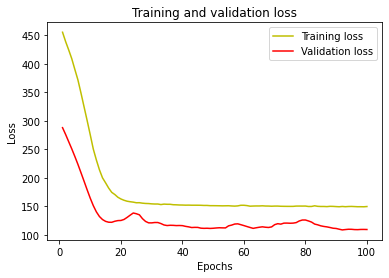


Predicted values are: 
 [[23.150425 ]
 [23.003769 ]
 [ 5.71262  ]
 [ 7.6516304]
 [22.634619 ]]

Real values are: 
 29530    10.050
29531    18.952
29532     3.084
29533    20.501
29534    35.188
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 14ms/step - loss: 69.0735 - mean_absolute_error: 6.6256

Mean squared error from neural net: 
 69.07351684570312

Mean absolute error from neural net: 
 6.6255645751953125


ValueError: in user code:

    /Applications/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /Applications/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Applications/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Applications/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Applications/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /Applications/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:835 run_step  **
        outputs = model.train_step(data)
    /Applications/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:787 train_step
        y_pred = self(x, training=True)
    /Applications/anaconda3/lib/python3.8/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /Applications/anaconda3/lib/python3.8/site-packages/keras/engine/input_spec.py:229 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_1 is incompatible with the layer: : expected min_ndim=3, found ndim=2. Full shape received: (None, 11)


In [18]:
# the model function is called running each model and returning the total values to find averages
ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae = models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled, ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae)

In [ ]:
# relevant totals are then incremented
D_mse = D_mse + Val_mse
D_mae = D_mae + Val_mae

W2_mse = W2_mse + Val_mse
W2_mae = W2_mae + Val_mae

Mean squared error from neural net: 
 73.11471557617188

Mean absolute error from neural net: 
 6.979510307312012

 Mean squared error using Random Forest:  148.65500502650914

Mean absolute error Using Random Forest:  10.139829090909092


# Predict 3 Days with 2 Weeks in May 2021 - All SpaceID

In [20]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'] == 5]
train = train.loc[train['connectionTime_day'].isin([7,8,9,10,11,12,13,14,15,16,17,18,19,20,21])]

In [21]:
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 5]

In [22]:
test = test.loc[test['connectionTime_day'].isin([22,23,24])]

In [23]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [24]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               1536      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________


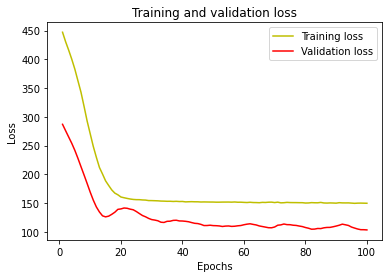


Predicted values are: 
 [[27.164646]
 [27.1068  ]
 [ 8.445383]
 [ 8.071072]
 [26.944702]]

Real values are: 
 29530    10.050
29531    18.952
29532     3.084
29533    20.501
29534    35.188
Name: kWhDelivered, dtype: float64
2/2 [==============================] - 0s 2ms/step - loss: 110.2946 - mean_absolute_error: 8.6454

Mean squared error from neural net: 
 110.29463958740234

Mean absolute error from neural net: 
 8.645392417907715

Predicted values are:
  [[0.00528858 0.00665519 0.00643391 0.0060521  0.00572007 0.00597677
  0.00563063 0.00556474 0.0061792  0.00582845 0.00634057 0.00573524
  0.00509832 0.00589275 0.00561546 0.00566721 0.00522507 0.00564499
  0.00555583 0.00604364 0.00599525 0.00644574 0.00649164 0.00574561
  0.00575577 0.00532281 0.00589453 0.0053635  0.00570451 0.0062667
  0.00478437 0.00642815 0.00725346 0.00600967 0.00578095 0.00619896
  0.00581924 0.00554369 0.00596502 0.00585692 0.0054586  0.00632776
  0.00600012 0.00626497 0.00667003 0.00514579 0.00557586 0.0

2/2 [==============================] - 0s 2ms/step - loss: 209.0930 - mean_absolute_error: 10.2987

Mean squared error from Convolutional neural net:  209.0929718017578

Mean absolute error from Convolutional neural net:  10.298651695251465

Mean squared error from linear regression:  336.49808908576375

Mean absolute error from linear regression:  12.149743707123902

Mean squared error using decision tree:  224.6200447894737

Mean absolute error using decision tree:  9.023894736842108

Mean squared error using Random Forest:  118.26499309245271

Mean absolute error Using Random Forest:  8.835013684210532

 The features ranking by importance to the RF Model

 doneChargingTime            0.272714
disconnectTime              0.247277
connectionTime              0.240627
spaceID                     0.094457
connectionTime_dayofweek    0.090159
connectionTime_day          0.047802
connectionTime_week         0.006964
_id                         0.000000
siteID                      0.000000

In [25]:
ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae = models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled, ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae)

In [26]:
D3_mse = D3_mse + Val_mse
D3_mae = D3_mae + Val_mae

W2_mse = W2_mse + Val_mse
W2_mae = W2_mae + Val_mae

Mean squared error from neural net: 
 105.27364349365234

Mean absolute error from neural net: 
 8.460984230041504


Mean squared error using Random Forest:  118.26499309245271

Mean absolute error Using Random Forest:  8.835013684210532

# Predict 5 Days with 2 Weeks of Data

In [27]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'] == 5]
train = train.loc[train['connectionTime_day'].isin([7,8,9,10,11,12,13,14,15,16,17,18,19,20,21])]

In [28]:
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 5]

In [29]:
test = test.loc[test['connectionTime_day'].isin([22,23,24,25,26])]

In [30]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [31]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 128)               1536      
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________


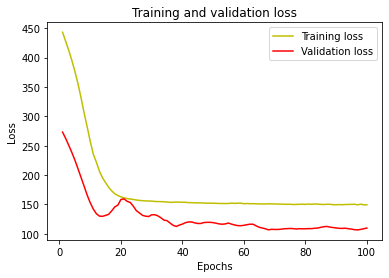


Predicted values are: 
 [[24.737204]
 [24.71277 ]
 [ 9.406624]
 [ 9.176279]
 [24.65068 ]]

Real values are: 
 29530    10.050
29531    18.952
29532     3.084
29533    20.501
29534    35.188
Name: kWhDelivered, dtype: float64
3/3 [==============================] - 0s 1ms/step - loss: 132.6852 - mean_absolute_error: 8.5777

Mean squared error from neural net: 
 132.68515014648438

Mean absolute error from neural net: 
 8.577713966369629

Predicted values are:
  [[0.00577154 0.00545727 0.00615765 0.00586223 0.00558583 0.0054897
  0.00622796 0.00535806 0.0065288  0.00601372 0.00581486 0.00536348
  0.00586779 0.00550164 0.00593278 0.00584717 0.00572041 0.00563405
  0.00560471 0.00587953 0.00525487 0.00590424 0.00575451 0.00669125
  0.0052205  0.00584641 0.00478615 0.00614636 0.00547634 0.00609579
  0.00599963 0.00539326 0.00569047 0.00606858 0.00550932 0.00615563
  0.00596908 0.00576979 0.00648619 0.00597866 0.00659543 0.0050596
  0.0055859  0.00549349 0.00590451 0.00553173 0.00547291 0.00

3/3 [==============================] - 0s 1ms/step - loss: 267.7458 - mean_absolute_error: 11.6811

Mean squared error from Convolutional neural net:  267.7457580566406

Mean absolute error from Convolutional neural net:  11.681137084960938

Mean squared error from linear regression:  169.91721082097612

Mean absolute error from linear regression:  9.59207799610515

Mean squared error using decision tree:  238.68213326865674

Mean absolute error using decision tree:  11.487626865671643

Mean squared error using Random Forest:  158.4821466998239

Mean absolute error Using Random Forest:  10.196450149253732

 The features ranking by importance to the RF Model

 doneChargingTime            0.272714
disconnectTime              0.247277
connectionTime              0.240627
spaceID                     0.094457
connectionTime_dayofweek    0.090159
connectionTime_day          0.047802
connectionTime_week         0.006964
_id                         0.000000
siteID                      0.000000

In [32]:
ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae = models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled, ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae)

In [33]:
D5_mse = D5_mse + Val_mse
D5_mae = D5_mae + Val_mae

W2_mse = W2_mse + Val_mse
W2_mae = W2_mae + Val_mae

Mean squared error from neural net: 
 133.3348846435547

Mean absolute error from neural net: 
 8.514357566833496

 Mean squared error using Random Forest:  158.4821466998239

Mean absolute error Using Random Forest:  10.196450149253732

# Predict 1 Week with 2 weeks of data

In [34]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'] == 5]
train = train.loc[train['connectionTime_day'].isin([7,8,9,10,11,12,13,14,15,16,17,18,19,20,21])]

In [35]:
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 5]

In [36]:
test = test.loc[test['connectionTime_day'].isin([22,23,24,25,26,27,28])]

In [37]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [38]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 128)               1536      
_________________________________________________________________
dense_16 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________


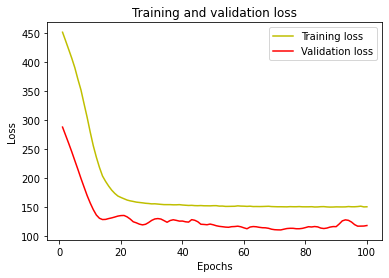


Predicted values are: 
 [[23.147518]
 [23.12355 ]
 [ 9.734891]
 [ 9.329319]
 [23.057041]]

Real values are: 
 29530    10.050
29531    18.952
29532     3.084
29533    20.501
29534    35.188
Name: kWhDelivered, dtype: float64
3/3 [==============================] - 0s 2ms/step - loss: 141.1441 - mean_absolute_error: 8.9982

Mean squared error from neural net: 
 141.14413452148438

Mean absolute error from neural net: 
 8.998169898986816

Predicted values are:
  [[0.00547417 0.00618395 0.00604713 0.0060611  0.00603073 0.00595825
  0.00524143 0.00547306 0.00658994 0.0061322  0.00630112 0.00500669
  0.00563715 0.00677895 0.00626301 0.00683683 0.00628802 0.00531492
  0.00606687 0.0063153  0.00583718 0.00593535 0.00578121 0.00540275
  0.00660728 0.00578533 0.00594486 0.00583462 0.00647336 0.00655452
  0.00629153 0.00608376 0.00580729 0.00618409 0.00558299 0.00566164
  0.00610809 0.0069487  0.00583503 0.00620829 0.00493299 0.00620534
  0.00555643 0.00551278 0.00499591 0.0063081  0.00579828 0.

3/3 [==============================] - 0s 2ms/step - loss: 315.9516 - mean_absolute_error: 12.8930

Mean squared error from Convolutional neural net:  315.95159912109375

Mean absolute error from Convolutional neural net:  12.893013000488281

Mean squared error from linear regression:  142.27094868893911

Mean absolute error from linear regression:  9.24767487246975

Mean squared error using decision tree:  367.0232467204301

Mean absolute error using decision tree:  13.821817204301077

Mean squared error using Random Forest:  187.209413674942

Mean absolute error Using Random Forest:  10.53328107526882

 The features ranking by importance to the RF Model

 doneChargingTime            0.272714
disconnectTime              0.247277
connectionTime              0.240627
spaceID                     0.094457
connectionTime_dayofweek    0.090159
connectionTime_day          0.047802
connectionTime_week         0.006964
_id                         0.000000
siteID                      0.000000
c

In [39]:
ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae = models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled, ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae)

In [40]:
W_mse = W_mse + Val_mse
W_mae = W_mae + Val_mae

W2_mse = W2_mse + Val_mse
W2_mae = W2_mae + Val_mae

Mean squared error from neural net: 
 139.96694946289062

Mean absolute error from neural net: 
 8.832489013671875

Mean squared error from linear regression:  142.27094868893911

Mean absolute error from linear regression:  9.24767487246975


# Predict 1 Day with 1 Month of Data

In [41]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'] == 3]

In [42]:
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 4]

In [43]:
test = test.loc[test['connectionTime_day'].isin([1])]

In [44]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [45]:
x_trainScaled.shape

(253, 11)

In [46]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 128)               1536      
_________________________________________________________________
dense_21 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________


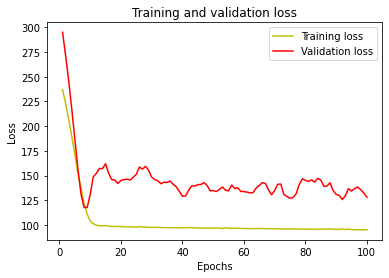


Predicted values are: 
 [[16.170624]
 [16.131296]
 [ 5.9044  ]
 [ 7.148415]
 [17.267939]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 35ms/step - loss: 162.0786 - mean_absolute_error: 7.6533

Mean squared error from neural net: 
 162.0785675048828

Mean absolute error from neural net: 
 7.653307914733887

Predicted values are:
  [[0.0038503  0.00419098 0.0040021  ... 0.00401657 0.00420704 0.0041537 ]
 [0.00384897 0.0041806  0.00400705 ... 0.00401704 0.00419886 0.00415843]
 [0.00400787 0.00406401 0.0040444  ... 0.00386268 0.00397284 0.00405761]
 [0.00391673 0.00402476 0.00417048 ... 0.00376377 0.00400438 0.00415256]
 [0.00378341 0.00422914 0.00396992 ... 0.00384983 0.00404061 0.00424441]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
1/1 [=============================

In [47]:
ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae = models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled, ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae)

In [48]:
D_mse = D_mse + Val_mse
D_mae = D_mae + Val_mae

M1_mse = M1_mse + Val_mse
M1_mae = M1_mae + Val_mae

Mean squared error from neural net: 
 160.7447967529297

Mean absolute error from neural net: 
 7.436678886413574

 Mean squared error from Convolutional neural net:  375.9288024902344

Mean absolute error from Convolutional neural net:  12.156847953796387

# Predict 3 Days with 1 month of Data

In [49]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'] == 3]

In [50]:
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 4]

In [51]:
test = test.loc[test['connectionTime_day'].isin([1,2,3])]

In [52]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [53]:
x_trainScaled.shape

(253, 11)

In [54]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 128)               1536      
_________________________________________________________________
dense_26 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________


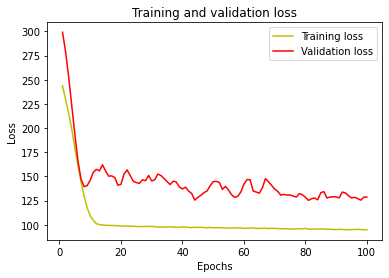


Predicted values are: 
 [[11.992939 ]
 [11.9548025]
 [ 6.179864 ]
 [ 5.955994 ]
 [11.432129 ]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 14ms/step - loss: 209.1719 - mean_absolute_error: 9.3918

Mean squared error from neural net: 
 209.17190551757812

Mean absolute error from neural net: 
 9.391789436340332

Predicted values are:
  [[0.00423228 0.00438143 0.00395456 ... 0.00395128 0.00386599 0.00414754]
 [0.00422869 0.00437545 0.00395301 ... 0.00394964 0.00386996 0.00414432]
 [0.00430188 0.00417441 0.0042637  ... 0.00384382 0.00354098 0.00377216]
 [0.00431282 0.00411609 0.00416666 ... 0.00388051 0.00368651 0.00379369]
 [0.00415216 0.00422601 0.00392405 ... 0.00390059 0.00396    0.00407459]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
1/1 [=======================

In [55]:
ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae = models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled, ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae)

In [56]:
D3_mse = D3_mse + Val_mse
D3_mae = D3_mae + Val_mae

M1_mse = M1_mse + Val_mse
M1_mae = M1_mae + Val_mae

Mean squared error from neural net: 
 213.64584350585938

Mean absolute error from neural net: 
 9.39246940612793

 Mean squared error using decision tree:  186.34709148387097

Mean absolute error using decision tree:  8.564


# Predict 5 Days with 1 Month of Data

In [57]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'] == 3]

In [58]:
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 4]

In [59]:
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5])]

In [60]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [61]:
x_trainScaled.shape

(253, 11)

In [62]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 128)               1536      
_________________________________________________________________
dense_31 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________


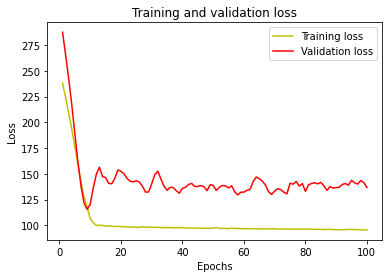


Predicted values are: 
 [[12.931686 ]
 [12.926541 ]
 [ 6.6582637]
 [ 6.635841 ]
 [12.88312  ]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
2/2 [==============================] - 0s 5ms/step - loss: 197.8009 - mean_absolute_error: 9.7500

Mean squared error from neural net: 
 197.8009490966797

Mean absolute error from neural net: 
 9.750001907348633

Predicted values are:
  [[0.00386071 0.00417777 0.00414822 ... 0.00377349 0.00392595 0.00372604]
 [0.00386106 0.0041745  0.0041476  ... 0.00377506 0.00393011 0.00372676]
 [0.00375519 0.00411501 0.00403085 ... 0.00367678 0.00385419 0.00371095]
 [0.00380072 0.00405324 0.00399853 ... 0.00373082 0.00390146 0.00379587]
 [0.00387338 0.00407091 0.00414039 ... 0.00380472 0.00403841 0.00376449]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
2/2 [=========================

In [63]:
ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae = models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled, ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae)

In [64]:
D5_mse = D5_mse + Val_mse
D5_mae = D5_mae + Val_mae

M1_mse = M1_mse + Val_mse
M1_mae = M1_mae + Val_mae

Mean squared error from neural net: 
 198.32432556152344

Mean absolute error from neural net: 
 9.677536964416504


Mean squared error using Random Forest:  220.6186052555203

Mean absolute error Using Random Forest:  11.660016579549948

# Predict 1 Week with 1 Month of Data

In [65]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'] == 3]

In [66]:
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 4]

In [67]:
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [68]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [69]:
x_trainScaled.shape

(253, 11)

In [70]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 128)               1536      
_________________________________________________________________
dense_36 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________


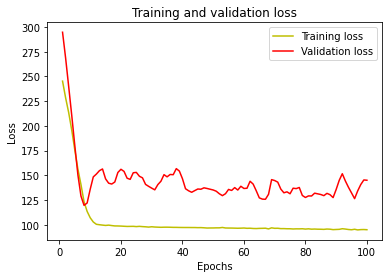


Predicted values are: 
 [[17.45765  ]
 [17.436253 ]
 [ 7.9334235]
 [ 7.7170715]
 [16.99053  ]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
3/3 [==============================] - 0s 1ms/step - loss: 169.6889 - mean_absolute_error: 9.3051

Mean squared error from neural net: 
 169.68894958496094

Mean absolute error from neural net: 
 9.305074691772461

Predicted values are:
  [[0.00423242 0.00380917 0.00397182 ... 0.0037691  0.00367836 0.00383302]
 [0.00423332 0.0038094  0.00397356 ... 0.00376908 0.00367984 0.00383308]
 [0.00395107 0.00377026 0.00389036 ... 0.00369603 0.00373575 0.00386366]
 [0.0039915  0.00377916 0.0039133  ... 0.00374285 0.00375842 0.0039014 ]
 [0.00425963 0.00381537 0.00400323 ... 0.00377118 0.00370908 0.00383399]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
3/3 [========================

In [71]:
ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae = models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled, ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae)

In [72]:
W_mse = W_mse + Val_mse
W_mae = W_mae + Val_mae

M1_mse = M1_mse + Val_mse
M1_mae = M1_mae + Val_mae

Mean squared error from neural net: 
 166.5867919921875

Mean absolute error from neural net: 
 9.034040451049805

 Mean squared error from linear regression:  218.3835207200644

Mean absolute error from linear regression:  10.310513898451116

# Predict 1 Day with 2 Months of Data

In [73]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'].isin([7, 8])]
                                                      
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 9]
test = test.loc[test['connectionTime_day'].isin([1])]

In [74]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [75]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 128)               1536      
_________________________________________________________________
dense_41 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________


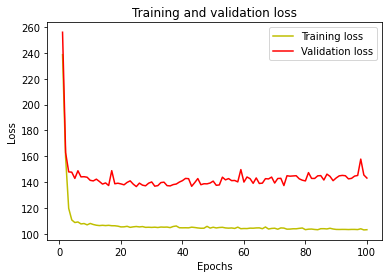


Predicted values are: 
 [[11.575358 ]
 [11.40097  ]
 [10.060037 ]
 [ 3.019351 ]
 [ 2.4896116]]

Real values are: 
 31131     0.901
31132     2.101
31133     3.152
31134     5.894
31135    31.942
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 16ms/step - loss: 86.0604 - mean_absolute_error: 6.7876

Mean squared error from neural net: 
 86.06040954589844

Mean absolute error from neural net: 
 6.787608623504639

Predicted values are:
  [[0.00092032 0.00097947 0.00091625 ... 0.00096494 0.00091493 0.00093752]
 [0.00091832 0.00098042 0.00091534 ... 0.0009653  0.00091433 0.00093947]
 [0.00092086 0.00097702 0.00091959 ... 0.00096338 0.0009197  0.00094146]
 [0.00093535 0.00095446 0.00094105 ... 0.00095616 0.00095307 0.00094687]
 [0.00093706 0.00095719 0.00093498 ... 0.00095694 0.00095392 0.0009446 ]]

Real values are: 
 31131     0.901
31132     2.101
31133     3.152
31134     5.894
31135    31.942
Name: kWhDelivered, dtype: float64
1/1 [=========================

In [76]:
ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae = models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled, ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae)

In [77]:
D_mse = D_mse + Val_mse
D_mae = D_mae + Val_mae

M2_mse = M2_mse + Val_mse
M2_mae = M2_mae + Val_mae

Mean squared error from neural net: 
 83.28107452392578

Mean absolute error from neural net: 
 6.621450424194336

Mean squared error using Random Forest:  87.59891941785604

Mean absolute error Using Random Forest:  7.123862400000002

# Predict 3 Days with 2 Months of Data

In [78]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'].isin([7, 8])]
                                                      
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 9]
test = test.loc[test['connectionTime_day'].isin([1,2,3])]

In [79]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [80]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 128)               1536      
_________________________________________________________________
dense_46 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________


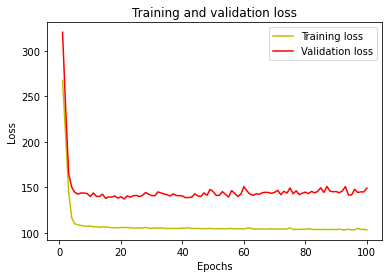


Predicted values are: 
 [[11.700909]
 [11.693552]
 [11.406935]
 [ 9.86792 ]
 [ 9.385988]]

Real values are: 
 31131     0.901
31132     2.101
31133     3.152
31134     5.894
31135    31.942
Name: kWhDelivered, dtype: float64
3/3 [==============================] - 0s 6ms/step - loss: 108.9072 - mean_absolute_error: 7.6459

Mean squared error from neural net: 
 108.90717315673828

Mean absolute error from neural net: 
 7.6459197998046875

Predicted values are:
  [[0.00096703 0.0009401  0.00092165 ... 0.00097832 0.00096081 0.00091767]
 [0.00096731 0.00093988 0.00092158 ... 0.00097838 0.00096046 0.00091791]
 [0.0009665  0.00094097 0.00092217 ... 0.00097734 0.00096015 0.0009194 ]
 [0.00096211 0.0009473  0.00092523 ... 0.00097121 0.00095882 0.00092829]
 [0.00096082 0.00095132 0.00092937 ... 0.00096779 0.00096167 0.00093004]]

Real values are: 
 31131     0.901
31132     2.101
31133     3.152
31134     5.894
31135    31.942
Name: kWhDelivered, dtype: float64
3/3 [============================

In [81]:
ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae = models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled, ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae)

In [82]:
D3_mse = D3_mse + Val_mse
D3_mae = D3_mae + Val_mae

M2_mse = M2_mse + Val_mse
M2_mae = M2_mae + Val_mae

Mean squared error from neural net: 
 102.65827178955078

Mean absolute error from neural net: 
 7.4129815101623535

Mean squared error using Random Forest:  113.78877579587008

Mean absolute error Using Random Forest:  7.631643458292483


# Predict 5 Days with 2 Months of Data

In [83]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'].isin([7, 8])]
                                                      
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 9]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5])]

In [84]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [85]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 128)               1536      
_________________________________________________________________
dense_51 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_52 (Dense)             (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________


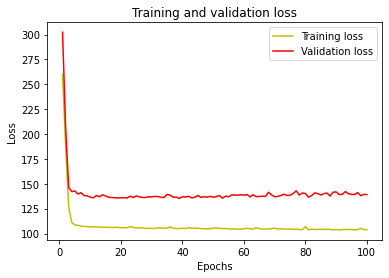


Predicted values are: 
 [[10.536271 ]
 [10.519266 ]
 [10.3760195]
 [ 9.540914 ]
 [ 9.333257 ]]

Real values are: 
 31131     0.901
31132     2.101
31133     3.152
31134     5.894
31135    31.942
Name: kWhDelivered, dtype: float64
3/3 [==============================] - 0s 1ms/step - loss: 119.0798 - mean_absolute_error: 7.5162

Mean squared error from neural net: 
 119.07984161376953

Mean absolute error from neural net: 
 7.516154766082764

Predicted values are:
  [[0.00098055 0.00100267 0.00097536 ... 0.00097255 0.00097354 0.00098129]
 [0.00098055 0.00100245 0.00097539 ... 0.00097258 0.00097342 0.00098178]
 [0.00097934 0.00100213 0.00097515 ... 0.00097199 0.00097318 0.00098079]
 [0.00097117 0.00100002 0.00097417 ... 0.0009692  0.00097277 0.00097654]
 [0.00096909 0.00100023 0.00097209 ... 0.00096836 0.0009723  0.00097214]]

Real values are: 
 31131     0.901
31132     2.101
31133     3.152
31134     5.894
31135    31.942
Name: kWhDelivered, dtype: float64
3/3 [========================

In [86]:
ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae = models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled, ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae)

In [87]:
D5_mse = D5_mse + Val_mse
D5_mae = D5_mae + Val_mae

M2_mse = M2_mse + Val_mse
M2_mae = M2_mae + Val_mae

Mean squared error from neural net: 
 117.1256103515625

Mean absolute error from neural net: 
 7.5160722732543945


Mean squared error using Random Forest:  100.1006992130904

Mean absolute error Using Random Forest:  7.348763723404256

# Predict 1 Week with 2 Months of Data

In [88]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'].isin([7, 8])]
                                                      
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 9]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [89]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [90]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (Dense)             (None, 128)               1536      
_________________________________________________________________
dense_56 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_57 (Dense)             (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________


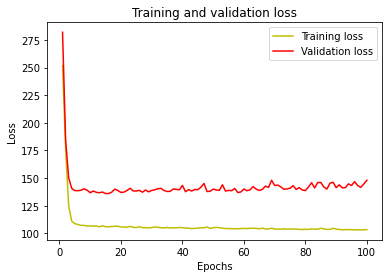


Predicted values are: 
 [[7.137927 ]
 [7.1266875]
 [7.0250893]
 [6.48035  ]
 [6.397981 ]]

Real values are: 
 31131     0.901
31132     2.101
31133     3.152
31134     5.894
31135    31.942
Name: kWhDelivered, dtype: float64
5/5 [==============================] - 0s 2ms/step - loss: 102.5145 - mean_absolute_error: 6.8787

Mean squared error from neural net: 
 102.51449584960938

Mean absolute error from neural net: 
 6.878661632537842

Predicted values are:
  [[0.0009509  0.00094162 0.00097665 ... 0.00091914 0.00089061 0.00092678]
 [0.00095088 0.00094151 0.00097688 ... 0.00091898 0.00089077 0.00092653]
 [0.00095166 0.00094195 0.00097604 ... 0.0009195  0.00089189 0.00092763]
 [0.00095572 0.00094472 0.00097109 ... 0.00092286 0.00089915 0.00093371]
 [0.00095707 0.0009458  0.00096837 ... 0.00092514 0.00090094 0.00093725]]

Real values are: 
 31131     0.901
31132     2.101
31133     3.152
31134     5.894
31135    31.942
Name: kWhDelivered, dtype: float64
5/5 [=============================

In [91]:
ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae = models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled, ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae)

In [92]:
W_mse = W_mse + Val_mse
W_mae = W_mae + Val_mae

M2_mse = M2_mse + Val_mse
M2_mae = M2_mae + Val_mae

Best 2:

Mean squared error from neural net: 
 104.15814971923828

Mean absolute error from neural net: 
 6.946341037750244

 Mean squared error using Random Forest:  106.3441792968664

Mean absolute error Using Random Forest:  6.811379829758829



# Predict 1 Day with 3 months

In [93]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'].isin([1, 2, 3])]
                                                      
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 4]
test = test.loc[test['connectionTime_day'] == 1]

In [94]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [95]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 128)               1536      
_________________________________________________________________
dense_61 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_62 (Dense)             (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________


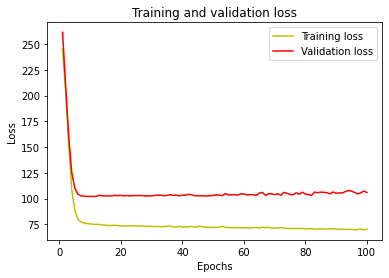


Predicted values are: 
 [[18.503798 ]
 [18.602444 ]
 [ 2.1322122]
 [ 5.5853505]
 [20.976671 ]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 13ms/step - loss: 141.2771 - mean_absolute_error: 7.5551

Mean squared error from neural net: 
 141.2771453857422

Mean absolute error from neural net: 
 7.555084228515625

Predicted values are:
  [[0.00167594 0.00172645 0.00165935 ... 0.00160063 0.0016425  0.00157947]
 [0.00167959 0.00172701 0.00166264 ... 0.00160095 0.00164525 0.00157649]
 [0.00166711 0.00161165 0.00162025 ... 0.00159383 0.0016709  0.00154203]
 [0.00169581 0.00164311 0.00164399 ... 0.00161315 0.00164804 0.00157546]
 [0.00168937 0.0017096  0.00167918 ... 0.00161488 0.00166729 0.00157222]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
1/1 [========================

In [96]:
ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae = models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled, ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae)

In [97]:
D_mse = D_mse + Val_mse
D_mae = D_mae + Val_mae

M3_mse = M3_mse + Val_mse
M3_mae = M3_mae + Val_mae

Best 2:

Mean squared error from neural net: 
 140.70570373535156

Mean absolute error from neural net: 
 7.819906711578369

Mean squared error using decision tree:  130.75000129999998

Mean absolute error using decision tree:  6.7923

# Predict 3 Days with 3 months

In [98]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'].isin([1, 2, 3])]
                                                      
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 4]
test = test.loc[test['connectionTime_day'].isin([1,2,3])]

In [99]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [100]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_65 (Dense)             (None, 128)               1536      
_________________________________________________________________
dense_66 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_67 (Dense)             (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________


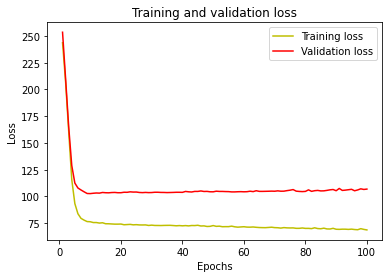


Predicted values are: 
 [[18.50459  ]
 [18.452436 ]
 [ 3.4214675]
 [ 3.080504 ]
 [17.196825 ]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 14ms/step - loss: 189.1021 - mean_absolute_error: 8.7368

Mean squared error from neural net: 
 189.1021270751953

Mean absolute error from neural net: 
 8.736754417419434

Predicted values are:
  [[0.0017036  0.00171152 0.00164674 ... 0.00155619 0.00167533 0.00156342]
 [0.00170259 0.00171089 0.00164585 ... 0.00155825 0.00167497 0.00156425]
 [0.00166    0.0016874  0.00157513 ... 0.00153245 0.00159838 0.00155876]
 [0.00164703 0.00166004 0.0015638  ... 0.00157883 0.00161796 0.00159211]
 [0.00168242 0.00169242 0.00162997 ... 0.00160489 0.00166796 0.00158048]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
1/1 [========================

In [101]:
ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae = models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled, ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae)

In [102]:
D3_mse = D3_mse + Val_mse
D3_mae = D3_mae + Val_mae

M3_mse = M3_mse + Val_mse
M3_mae = M3_mae + Val_mae

Mean squared error from neural net: 
 187.8616943359375

Mean absolute error from neural net: 
 8.869044303894043

 Mean squared error using Random Forest:  183.2863459959755

Mean absolute error Using Random Forest:  10.364935468369174

# Predict 5 Days with 3 months

In [103]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'].isin([1, 2, 3])]
                                                      
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 4]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5])]

In [104]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [105]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_70 (Dense)             (None, 128)               1536      
_________________________________________________________________
dense_71 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_72 (Dense)             (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________


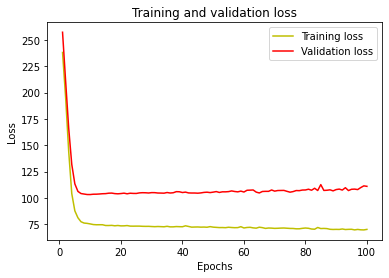


Predicted values are: 
 [[17.10494  ]
 [17.124746 ]
 [ 3.0966046]
 [ 3.7212396]
 [17.713194 ]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
2/2 [==============================] - 0s 2ms/step - loss: 158.2703 - mean_absolute_error: 8.0138

Mean squared error from neural net: 
 158.270263671875

Mean absolute error from neural net: 
 8.013827323913574

Predicted values are:
  [[0.00162046 0.00164601 0.00158054 ... 0.00156773 0.0016037  0.00160228]
 [0.00162039 0.00164569 0.00158139 ... 0.00156796 0.00160401 0.00160272]
 [0.00164302 0.00167631 0.00165306 ... 0.00165679 0.00166138 0.00157325]
 [0.00163617 0.00167269 0.00166002 ... 0.00165954 0.00165938 0.001581  ]
 [0.0016177  0.00163852 0.00159865 ... 0.00157151 0.00161192 0.00161476]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
2/2 [==========================

In [106]:
ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae = models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled, ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae)

In [107]:
D5_mse = D5_mse + Val_mse
D5_mae = D5_mae + Val_mae

M3_mse = M3_mse + Val_mse
M3_mae = M3_mae + Val_mae

Mean squared error from neural net: 
 160.44891357421875

Mean absolute error from neural net: 
 8.013179779052734

Mean squared error using Random Forest:  163.33505718087187

Mean absolute error Using Random Forest:  10.224571321158745

# Predict 1 Week with 3 months

In [108]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'].isin([1, 2, 3])]
                                                      
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 4]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [109]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [110]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_75 (Dense)             (None, 128)               1536      
_________________________________________________________________
dense_76 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_77 (Dense)             (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________


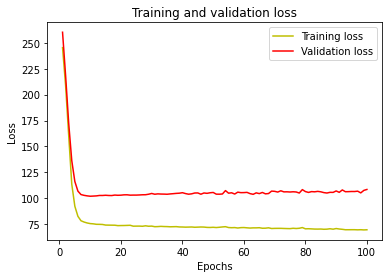


Predicted values are: 
 [[21.128603 ]
 [21.135159 ]
 [ 6.1243486]
 [ 6.2764935]
 [21.365583 ]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
3/3 [==============================] - 0s 1ms/step - loss: 142.1442 - mean_absolute_error: 7.7368

Mean squared error from neural net: 
 142.14418029785156

Mean absolute error from neural net: 
 7.7368364334106445

Predicted values are:
  [[0.00158452 0.0016554  0.00166653 ... 0.00154732 0.00178878 0.00168669]
 [0.00158445 0.00165545 0.0016662  ... 0.0015476  0.00178799 0.0016865 ]
 [0.0015739  0.00165168 0.00159683 ... 0.00160004 0.00181158 0.00167908]
 [0.00158101 0.00165869 0.00159279 ... 0.00160042 0.00178306 0.00167359]
 [0.00158502 0.00165323 0.00166086 ... 0.00155205 0.00177358 0.00168511]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
3/3 [=======================

In [111]:
ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae = models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled, ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae)

In [112]:
W_mse = W_mse + Val_mse
W_mae = W_mae + Val_mae

M3_mse = M3_mse + Val_mse
M3_mae = M3_mae + Val_mae

Mean squared error from neural net: 
 139.3793182373047

Mean absolute error from neural net: 
 7.571944236755371

 Mean squared error using Random Forest:  159.6135360726889

Mean absolute error Using Random Forest:  8.76255422973079

# Predict 1 Day with 6 months

In [113]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'].isin([1, 2, 3, 4, 5, 6])]
                                                      
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 4]
test = test.loc[test['connectionTime_day'] == 1]

In [114]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [115]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_80 (Dense)             (None, 128)               1536      
_________________________________________________________________
dense_81 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_82 (Dense)             (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________


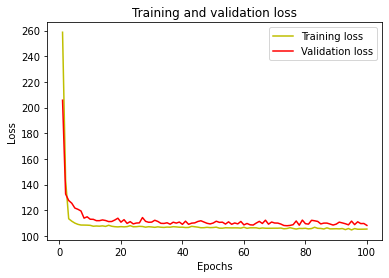


Predicted values are: 
 [[19.787636 ]
 [19.904303 ]
 [ 4.9285994]
 [ 7.875389 ]
 [23.180138 ]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 14ms/step - loss: 138.9943 - mean_absolute_error: 8.3447

Mean squared error from neural net: 
 138.99427795410156

Mean absolute error from neural net: 
 8.344724655151367

Predicted values are:
  [[0.00057417 0.00058855 0.00059197 ... 0.00059787 0.00058562 0.00058513]
 [0.00057434 0.0005882  0.00059161 ... 0.00059732 0.00058584 0.0005853 ]
 [0.00057815 0.00058855 0.00059597 ... 0.00059694 0.00058825 0.00058813]
 [0.00058365 0.0005855  0.00059865 ... 0.0006043  0.00058689 0.00058387]
 [0.00058435 0.00057425 0.00058567 ... 0.00059029 0.00058749 0.00058591]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
1/1 [=======================

In [116]:
ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae = models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled, ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae)

In [117]:
D_mse = D_mse + Val_mse
D_mae = D_mae + Val_mae

M6_mse = M6_mse + Val_mse
M6_mae = M6_mae + Val_mae

Best 2:

Mean squared error from neural net: 
 137.43057250976562

Mean absolute error from neural net: 
 8.427358627319336


Mean squared error using Random Forest:  139.48872427732

Mean absolute error Using Random Forest:  8.705460000000002

# Predict 3 Days with 6 months

In [118]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'].isin([1, 2, 3, 4, 5, 6])]
                                                      
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 4]
test = test.loc[test['connectionTime_day'].isin([1,2,3])]

In [119]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [120]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_85 (Dense)             (None, 128)               1536      
_________________________________________________________________
dense_86 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_87 (Dense)             (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________


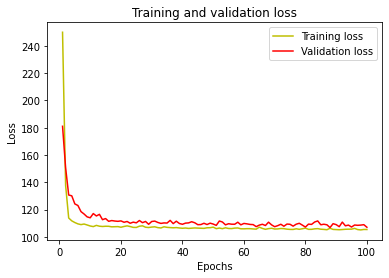


Predicted values are: 
 [[14.403899 ]
 [14.37635  ]
 [ 5.784436 ]
 [ 6.0170627]
 [13.686073 ]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 14ms/step - loss: 176.2166 - mean_absolute_error: 8.8752

Mean squared error from neural net: 
 176.21658325195312

Mean absolute error from neural net: 
 8.875224113464355

Predicted values are:
  [[0.00057299 0.00058785 0.00060019 ... 0.00057247 0.00058094 0.00057125]
 [0.00057306 0.00058791 0.00060009 ... 0.00057268 0.00058105 0.00057159]
 [0.00058107 0.00061529 0.00059254 ... 0.00057127 0.00057909 0.00055731]
 [0.00058592 0.00061351 0.00059127 ... 0.00057461 0.00058379 0.00056564]
 [0.00057481 0.00058979 0.0005955  ... 0.00057566 0.00058217 0.00057635]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
1/1 [=======================

In [121]:
ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae = models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled, ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae)

In [122]:
D3_mse = D3_mse + Val_mse
D3_mae = D3_mae + Val_mae

M6_mse = M6_mse + Val_mse
M6_mae = M6_mae + Val_mae

Best 2:

Mean squared error from neural net: 
 168.54148864746094

Mean absolute error from neural net: 
 8.720255851745605

 Mean squared error using Random Forest:  278.053234980616

Mean absolute error Using Random Forest:  14.620022903225802


# Predict 5 Days with 6 months

In [123]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'].isin([1, 2, 3, 4, 5, 6])]
                                                      
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 4]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5])]

In [124]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [125]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_90 (Dense)             (None, 128)               1536      
_________________________________________________________________
dense_91 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_92 (Dense)             (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________


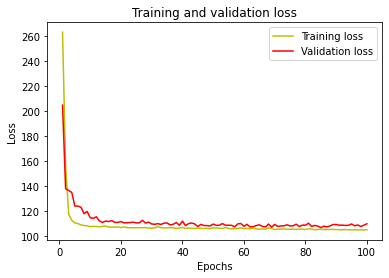

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7fce69add790>
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.8/weakref.py", line 345, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 



Predicted values are: 
 [[14.940357 ]
 [14.939748 ]
 [ 6.224266 ]
 [ 6.7047954]
 [14.946829 ]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
2/2 [==============================] - 0s 2ms/step - loss: 170.7585 - mean_absolute_error: 8.3962

Mean squared error from neural net: 
 170.7584686279297

Mean absolute error from neural net: 
 8.39620304107666

Predicted values are:
  [[0.00059287 0.00059352 0.00057787 ... 0.00059604 0.00058702 0.00058066]
 [0.00059286 0.00059351 0.00057801 ... 0.00059608 0.00058699 0.00058079]
 [0.00059832 0.0006031  0.00058531 ... 0.00058592 0.00058493 0.00058086]
 [0.00059915 0.00060291 0.00058659 ... 0.00058996 0.00058878 0.0005865 ]
 [0.00059341 0.00059282 0.00058094 ... 0.00059649 0.00058641 0.00058409]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
2/2 [==========================

In [126]:
ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae = models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled, ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae)

In [127]:
D5_mse = D5_mse + Val_mse
D5_mae = D5_mae + Val_mae

M6_mse = M6_mse + Val_mse
M6_mae = M6_mae + Val_mae

Best 2:

Mean squared error from neural net: 
 165.61785888671875

Mean absolute error from neural net: 
 8.66168212890625

 Mean squared error using Random Forest:  272.07574671006506

Mean absolute error Using Random Forest:  14.128006579549945


# Predict 1 Week with 6 months

In [128]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'].isin([1, 2, 3, 4, 5, 6])]
                                                      
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 4]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [129]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [130]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_95 (Dense)             (None, 128)               1536      
_________________________________________________________________
dense_96 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_97 (Dense)             (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________


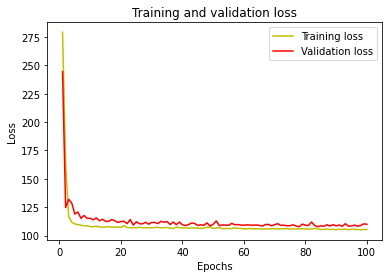


Predicted values are: 
 [[18.723295 ]
 [18.725124 ]
 [ 6.7129517]
 [ 6.637285 ]
 [18.846127 ]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
3/3 [==============================] - 0s 1ms/step - loss: 148.1317 - mean_absolute_error: 8.4770

Mean squared error from neural net: 
 148.13169860839844

Mean absolute error from neural net: 
 8.477023124694824

Predicted values are:
  [[0.00058433 0.00062263 0.00056934 ... 0.00060628 0.0006509  0.00056457]
 [0.00058437 0.00062248 0.00056939 ... 0.0006062  0.00065071 0.00056469]
 [0.0005773  0.00061532 0.00057806 ... 0.00060084 0.00064728 0.00055865]
 [0.00057754 0.00061138 0.00058069 ... 0.00059848 0.00064049 0.00056129]
 [0.00058535 0.00061859 0.00057086 ... 0.00060401 0.00064568 0.00056699]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
3/3 [========================

In [131]:
ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae = models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled, ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae)

In [132]:
W_mse = W_mse + Val_mse
W_mae = W_mae + Val_mae

M6_mse = M6_mse + Val_mse
M6_mae = M6_mae + Val_mae

Best 2:

Mean squared error from neural net: 
 149.21420288085938

Mean absolute error from neural net: 
 8.736455917358398

 Mean squared error using Random Forest:  267.29792056790865

Mean absolute error Using Random Forest:  14.550505776375797


# Predict one day with 1 year of data

In [133]:
train = df.loc[df['connectionTime_year'] == 2018]

In [134]:
test = df.loc[df['connectionTime_year']==2019]
test = test.loc[test['connectionTime_month'] == 1]
test = test.loc[test['connectionTime_day'] == 1]

In [135]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [136]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_100 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_101 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_102 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________


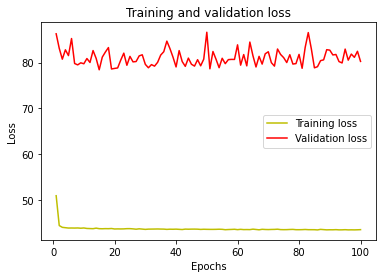


Predicted values are: 
 [[ 4.604831 ]
 [ 1.9369769]
 [ 4.879692 ]
 [12.949108 ]
 [ 5.7055254]]

Real values are: 
 15297    43.114
15298     3.250
15299     0.900
15300    12.534
15301     0.883
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 13ms/step - loss: 190.1031 - mean_absolute_error: 8.3655

Mean squared error from neural net: 
 190.10311889648438

Mean absolute error from neural net: 
 8.365504264831543

Predicted values are:
  [[6.5078049e-05 6.4989341e-05 6.5112428e-05 ... 6.5000531e-05
  6.5249995e-05 6.4695443e-05]
 [6.4876651e-05 6.4596163e-05 6.4639404e-05 ... 6.5068001e-05
  6.5408647e-05 6.4051281e-05]
 [6.5282649e-05 6.5340675e-05 6.5327957e-05 ... 6.5331478e-05
  6.5273118e-05 6.5275657e-05]
 [6.5299668e-05 6.5436623e-05 6.5232292e-05 ... 6.5313441e-05
  6.5335451e-05 6.5173881e-05]
 [6.5295193e-05 6.5356908e-05 6.5339053e-05 ... 6.5327768e-05
  6.5290864e-05 6.5320724e-05]]

Real values are: 
 15297    43.114
15298     3.250
15299     0

In [ ]:
ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae = models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled, ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae)

In [ ]:
D_mse = D_mse + Val_mse
D_mae = D_mae + Val_mae

Y_mse = Y_mse + Val_mse
Y_mae = Y_mae + Val_mae

Mean squared error from neural net: 
 196.89022827148438

Mean absolute error from neural net: 
 8.821752548217773

 Mean squared error from Convolutional neural net:  247.55209350585938

Mean absolute error from Convolutional neural net:  9.516521453857422

# Predict 3 days with 1 year of data

In [ ]:
train = df.loc[df['connectionTime_year'] == 2018]

In [ ]:
test = df.loc[df['connectionTime_year']==2019]
test = test.loc[test['connectionTime_month'] == 1]
test = test.loc[test['connectionTime_day'].isin([1,2,3])]

In [ ]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [ ]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

In [ ]:
ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae = models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled, ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae)

In [ ]:
D3_mse = D3_mse + Val_mse
D3_mae = D3_mae + Val_mae

Y_mse = Y_mse + Val_mse
Y_mae = Y_mae + Val_mae

Mean squared error from neural net: 
 194.04220581054688

Mean absolute error from neural net: 
 10.17531681060791

 Mean squared error from Convolutional neural net:  285.1625061035156

Mean absolute error from Convolutional neural net:  11.897130966186523

# Predict 5 days with 1 year of data

In [ ]:
train = df.loc[df['connectionTime_year'] == 2018]

In [ ]:
test = df.loc[df['connectionTime_year']==2019]
test = test.loc[test['connectionTime_month'] == 1]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5])]

In [ ]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [ ]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

In [ ]:
ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae = models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled, ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae)

In [ ]:
D5_mse = D5_mse + Val_mse
D5_mae = D5_mae + Val_mae

Y_mse = Y_mse + Val_mse
Y_mae = Y_mae + Val_mae

Mean squared error from neural net: 
 204.65234375

Mean absolute error from neural net: 
 10.506291389465332

Mean squared error from Convolutional neural net:  243.2482147216797

Mean absolute error from Convolutional neural net:  11.08861255645752

# Predict 1 week with 1 year of data

In [ ]:
train = df.loc[df['connectionTime_year'] == 2018]

In [ ]:
test = df.loc[df['connectionTime_year']==2019]
test = test.loc[test['connectionTime_month'] == 1]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [ ]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [ ]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

In [ ]:
ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae = models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled, ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae)

In [ ]:
W_mse = W_mse + Val_mse
W_mae = W_mae + Val_mae

Y_mse = Y_mse + Val_mse
Y_mae = Y_mae + Val_mae

Mean squared error from neural net: 
 181.9652557373047

Mean absolute error from neural net: 
 9.92181396484375

Mean squared error using Random Forest:  265.9261997741879

Mean absolute error Using Random Forest:  12.808809250546634


# Overall All Spaces

When ran on the 24 different DataFrames the following models occured:

Sequential Neural Network: 24 Times

Convolutional Neural Network: 4 Times

Linear Regression: 2 Times

Decision Tree: 2 Times

Random Forest: 16 Times

# Best result

2 Months 1 Day

Mean squared error from neural net: 
 83.28107452392578

Mean absolute error from neural net: 
 6.621450424194336

Mean squared error using Random Forest:  87.59891941785604

Mean absolute error Using Random Forest:  7.123862400000002

# Best 3 Day result

2 Months 3 Days

Mean squared error from neural net: 
 102.65827178955078

Mean absolute error from neural net: 
 7.4129815101623535

Mean squared error using Random Forest:  113.78877579587008

Mean absolute error Using Random Forest:  7.631643458292483

# Best 5 day result

2 Months 5 Days

Mean squared error from neural net: 
 117.1256103515625

Mean absolute error from neural net: 
 7.5160722732543945


Mean squared error using Random Forest:  100.1006992130904

Mean absolute error Using Random Forest:  7.348763723404256

# Best 1 Week Result

Mean squared error from neural net: 
 104.15814971923828

Mean absolute error from neural net: 
 6.946341037750244

 Mean squared error using Random Forest:  106.3441792968664

Mean absolute error Using Random Forest:  6.811379829758829


In [ ]:
# return the totals for mean square and absolute error for each of the models examined
print("Totals \n",
      "ANN_mse: ", ANN_mse, " ANN_mae: ", ANN_mae, "\n CNN_mse: ", CNN_mse,
      " CNN_mae: ", CNN_mae, "\n RF_mse: ", RF_mse, " RF_mae: ", RF_mae,
      "\n DT_mse: ", DT_mse, "DT_mae, ", DT_mae,
      "\n LR_mse: ", LR_mse, "LR_mae: ", LR_mae)

# return the means for mean square and absolute error for each of the models examined 
print("\n\nAverages \n",
      "ANN_mse: ", ANN_mse/20, " ANN_mae: ", ANN_mae/20, "\n CNN_mse: ", 
      CNN_mse/20, " CNN_mae: ", CNN_mae/20, "\nRF_mse: ", RF_mse/20,
      " RF_mae: ", RF_mae/20, "\nDT_mse: ", DT_mse/20,
      "DT_mae, ", DT_mae/20, "\n LR_mse: ", LR_mse/20, "LR_mae: ", LR_mae/20)

In [ ]:
# return the means for mean square error for each testing and training time frame
print("\n\nAverages \n",
      "Training:\n",
      "1 Day mse: ", D_mse/6, "1 Day mae: ", D_mae/6,
     "\n3 Days mse: ", D3_mse/6, "3 Days mae: ", D3_mae/6,
      "\n5 Days mse: ", D5_mse/6, "5 Days mae: ", D5_mae/6,
      "\n1 Week mse: ", W_mse/6, "1 Week mae: ", W_mae/6,
      
      
     "\n\nTesting\n",
      "2 Weeks mse: ", W2_mse/4, "2 Weeks mae: ", W2_mae/4,
      "\n1 Month mse: ", M1_mse/4, "1 Month mae: ", M1_mae/4,
      "\n2 Months mse: ", M2_mse/4, "2 Months mae: ", M2_mae/4,
      "\n3 Months mse: ", M3_mse/4, "3 Months mae: ", M3_mae/4,
      "\n6 Months mse: ", M1_mse/4, "6 Months mae: ", M6_mae/4,
      "\n1 Year mse: ", Y_mse/4, "1 Year mae: ", Y_mae/4,
     )

In [ ]:
ANN_mse = 0
CNN_mse = 0
RF_mse = 0
DT_mse = 0
LR_mse = 0

ANN_mae = 0
CNN_mae = 0
RF_mae = 0
DT_mae = 0
LR_mae = 0

In [ ]:
# Train
M1_mse = 0
M6_mse = 0

#Test

D_mse = 0
W_mse = 0

# Train
M1_mae = 0
M6_mae = 0

#Test

D_mae = 0
W_mae = 0


In [ ]:
M1Count = 0
M6Count = 0
DCount = 0
WCount = 0

# Individual Spaces 

In [ ]:
#create unique list of names
UniqueNames = df.spaceID.unique()

#create a data frame dictionary to store your data frames
DataFrameDict = {elem : pd.DataFrame for elem in UniqueNames}

for key in DataFrameDict.keys():
    DataFrameDict[key] = df[:][df.spaceID == key]

In [ ]:
UniqueNames

# Space 324

# 1 month of training data to predict the demand of 1 space for 1 day

In [ ]:
train = DataFrameDict['CA-324'].loc[DataFrameDict['CA-324']['connectionTime_year'] == 2019]
train = train.loc[train['connectionTime_month'] == 1]

In [ ]:
test = DataFrameDict['CA-324'].loc[DataFrameDict['CA-324']['connectionTime_year'] == 2019]
test = test.loc[test['connectionTime_month'] == 2]
test = test.loc[test['connectionTime_day'] == 1]

In [ ]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [ ]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

In [ ]:
ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae = models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled, ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae)

In [ ]:
Val_mse

In [ ]:
M1_mse = M1_mse + Val_mse
M1_mae = M1_mae + Val_mae

D_mse = D_mse + Val_mse
D_mae = D_mae + Val_mae

In [ ]:
M1Count = M1Count + 1
DCount = DCount + 1

Mean squared error from neural net: 
 18.237812042236328

Mean absolute error from neural net: 
 4.270575046539307

 Mean squared error from linear regression:  10.540411559717693

Mean absolute error from linear regression:  3.2465999999565227

# 1 Month to predict 1 week

In [ ]:
train = DataFrameDict['CA-324'].loc[DataFrameDict['CA-324']['connectionTime_month'] == 6]
train = train.loc[train['connectionTime_year'] == 2018]

In [ ]:
test = DataFrameDict['CA-324'].loc[DataFrameDict['CA-324']['connectionTime_year'] == 2018]
test = test.loc[test['connectionTime_month'] == 7]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [ ]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [ ]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

In [ ]:
ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae = models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled, ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae)

In [ ]:
M1_mse = M1_mse + Val_mse
M1_mae = M1_mae + Val_mae

W_mse = W_mse + Val_mse
W_mae = W_mae + Val_mae

In [ ]:
M1Count = M1Count + 1
WCount = WCount + 1

Mean squared error from neural net: 
 179.09262084960938

Mean absolute error from neural net: 
 10.296606063842773

 Mean squared error using Random Forest:  124.18021324321256

Mean absolute error Using Random Forest:  7.787178750000004


# 6 Month training 1 week predicition

In [ ]:
train = DataFrameDict['CA-324'].loc[DataFrameDict['CA-324']['connectionTime_year'] == 2019]

train = train.loc[train['connectionTime_month'].isin([1,2,3,4,5,6])]

In [ ]:
test = DataFrameDict['CA-324'].loc[DataFrameDict['CA-324']['connectionTime_year'] == 2019]
test = test.loc[test['connectionTime_month'] == 7]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [ ]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [ ]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

In [ ]:
ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae = models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled, ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae)

In [ ]:
M6_mse = M6_mse + Val_mse
M6_mae = M6_mae + Val_mae

W_mse = W_mse + Val_mse
W_mae = W_mae + Val_mae

In [ ]:
M6Count = M6Count + 1
WCount = WCount + 1

Mean squared error from neural net: 
 87.76254272460938

Mean absolute error from neural net: 
 9.301206588745117

 Mean squared error from Convolutional neural net:  7.518273830413818

Mean absolute error from Convolutional neural net:  2.692187547683716

# Space 322

# 1 month of training data to predict the demand of 1 space for 1 day

In [ ]:
train = DataFrameDict['CA-322'].loc[DataFrameDict['CA-322']['connectionTime_year'] == 2019]
train = train.loc[train['connectionTime_month'] == 1]

In [ ]:
test = DataFrameDict['CA-322'].loc[DataFrameDict['CA-322']['connectionTime_year'] == 2019]
test = test.loc[test['connectionTime_month'] == 2]
test = test.loc[test['connectionTime_day'] == 1]

In [ ]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [ ]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

In [ ]:
ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae = models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled, ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae)

In [ ]:
M1_mse = M1_mse + Val_mse
M1_mae = M1_mae + Val_mae

D_mse = D_mse + Val_mse
D_mae = D_mae + Val_mae

In [ ]:
M1Count = M1Count + 1
DCount = DCount + 1

Mean squared error from linear regression:  23.0043599508838

Mean absolute error from linear regression:  4.796286058074914

Mean squared error using decision tree:  17.32224399999999

Mean absolute error using decision tree:  4.161999999999999

# 1 Month to predict 1 week

In [ ]:
train = DataFrameDict['CA-322'].loc[DataFrameDict['CA-322']['connectionTime_month'] == 6]
train = train.loc[train['connectionTime_year'] == 2018]

In [ ]:
test = DataFrameDict['CA-322'].loc[DataFrameDict['CA-322']['connectionTime_year'] == 2018]
test = test.loc[test['connectionTime_month'] == 7]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [ ]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [ ]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

In [ ]:
ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae = models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled, ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae)

In [ ]:
M1_mse = M1_mse + Val_mse
M1_mae = M1_mae + Val_mae

W_mse = W_mse + Val_mse
W_mae = W_mae + Val_mae

In [ ]:
M1Count = M1Count + 1
WCount = WCount + 1

Mean squared error from neural net: 
 115.94696044921875

Mean absolute error from neural net: 
 8.477322578430176

 Mean squared error from Convolutional neural net:  125.59464263916016

Mean absolute error from Convolutional neural net:  8.888972282409668


# 6 Month training 1 week predicition

In [ ]:
train = DataFrameDict['CA-322'].loc[DataFrameDict['CA-322']['connectionTime_year'] == 2019]

train = train.loc[train['connectionTime_month'].isin([1,2,3,4,5,6])]

In [ ]:
test = DataFrameDict['CA-322'].loc[DataFrameDict['CA-322']['connectionTime_year'] == 2019]
test = test.loc[test['connectionTime_month'] == 7]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [ ]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [ ]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

In [ ]:
ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae = models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled, ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae)

In [ ]:
M6_mse = M6_mse + Val_mse
M6_mae = M6_mae + Val_mae

W_mse = W_mse + Val_mse
W_mae = W_mae + Val_mae

In [ ]:
M6Count = M6Count + 1
WCount = WCount + 1

Mean squared error from neural net: 
 67.17460632324219

Mean absolute error from neural net: 
 7.740140438079834

 Mean squared error from Convolutional neural net:  28.86421775817871

Mean absolute error from Convolutional neural net:  3.136587381362915

# Space 497

# 1 month of training data to predict the demand of 1 space for 1 day

In [ ]:
train = DataFrameDict['CA-497'].loc[DataFrameDict['CA-497']['connectionTime_year'] == 2019]
train = train.loc[train['connectionTime_month'] == 1]

In [ ]:
test = DataFrameDict['CA-497'].loc[DataFrameDict['CA-497']['connectionTime_year'] == 2019]
test = test.loc[test['connectionTime_month'] == 2]
test = test.loc[test['connectionTime_day'] == 1]

In [ ]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [ ]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

In [ ]:
ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae = models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled, ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae)

In [ ]:
M1_mse = M1_mse + Val_mse
M1_mae = M1_mae + Val_mae

D_mse = D_mse + Val_mse
D_mae = D_mae + Val_mae

In [ ]:
M1Count = M1Count + 1
DCount = DCount + 1

Mean squared error from neural net: 
 33.54694366455078

Mean absolute error from neural net: 
 5.298711776733398

Mean squared error using Random Forest:  8.430320786899973

Mean absolute error Using Random Forest:  2.713869999999991

# 1 Month to predict 1 week

In [ ]:
train = DataFrameDict['CA-497'].loc[DataFrameDict['CA-497']['connectionTime_month'] == 6]
train = train.loc[train['connectionTime_year'] == 2018]

In [ ]:
test = DataFrameDict['CA-497'].loc[DataFrameDict['CA-497']['connectionTime_year'] == 2018]
test = test.loc[test['connectionTime_month'] == 7]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [ ]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [ ]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

In [ ]:
ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae = models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled, ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae)

In [ ]:
M1_mse = M1_mse + Val_mse
M1_mae = M1_mae + Val_mae

W_mse = W_mse + Val_mse
W_mae = W_mae + Val_mae

In [ ]:
M1Count = M1Count + 1
WCount = WCount + 1

Mean squared error from linear regression:  181.30599388416144

Mean absolute error from linear regression:  8.823666666480948

Mean squared error using Random Forest:  194.13588130859986

Mean absolute error Using Random Forest:  10.142719999999999

# 6 Month training 1 week predicition

In [ ]:
train = DataFrameDict['CA-497'].loc[DataFrameDict['CA-497']['connectionTime_year'] == 2019]

train = train.loc[train['connectionTime_month'].isin([1,2,3,4,5,6])]

In [ ]:
test = DataFrameDict['CA-497'].loc[DataFrameDict['CA-497']['connectionTime_year'] == 2019]
test = test.loc[test['connectionTime_month'] == 7]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [ ]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [ ]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

In [ ]:
ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae = models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled, ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae)

In [ ]:
M6_mse = M6_mse + Val_mse
M6_mae = M6_mae + Val_mae

W_mse = W_mse + Val_mse
W_mae = W_mae + Val_mae

In [ ]:
M6Count = M6Count + 1
WCount = WCount + 1

Mean squared error using decision tree:  386.35109000000006

Mean absolute error using decision tree:  14.173

Mean squared error using Random Forest:  318.0916757008996

Mean absolute error Using Random Forest:  15.14646999999999


# Space 303

# 1 month of training data to predict the demand of 1 space for 1 day

In [ ]:
train = DataFrameDict['CA-303'].loc[DataFrameDict['CA-303']['connectionTime_year'] == 2019]
train = train.loc[train['connectionTime_month'] == 1]

In [ ]:
test = DataFrameDict['CA-303'].loc[DataFrameDict['CA-303']['connectionTime_year'] == 2019]
test = test.loc[test['connectionTime_month'] == 2]
test = test.loc[test['connectionTime_day'] == 1]

In [ ]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [ ]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

In [ ]:
ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae = models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled, ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae)

In [ ]:
M1_mse = M1_mse + Val_mse
M1_mae = M1_mae + Val_mae

D_mse = D_mse + Val_mse
D_mae = D_mae + Val_mae

In [ ]:
M1Count = M1Count + 1
DCount = DCount + 1

Mean squared error from neural net: 
 46.19374465942383

Mean absolute error from neural net: 
 5.661655902862549

 Mean squared error using Random Forest:  97.00961524166672

Mean absolute error Using Random Forest:  9.839360000000003

# 1 Month to predict 1 week

In [ ]:
train = DataFrameDict['CA-303'].loc[DataFrameDict['CA-303']['connectionTime_month'] == 6]
train = train.loc[train['connectionTime_year'] == 2018]

In [ ]:
test = DataFrameDict['CA-303'].loc[DataFrameDict['CA-303']['connectionTime_year'] == 2018]
test = test.loc[test['connectionTime_month'] == 7]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [ ]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [ ]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

In [ ]:
ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae = models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled, ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae)

In [ ]:
M1_mse = M1_mse + Val_mse
M1_mae = M1_mae + Val_mae

W_mse = W_mse + Val_mse
W_mae = W_mae + Val_mae

In [ ]:
M1Count = M1Count + 1
WCount = WCount + 1

Mean squared error from neural net: 
 46.877540588378906

Mean absolute error from neural net: 
 5.940613269805908

 Mean squared error using Random Forest:  77.77993093784437

Mean absolute error Using Random Forest:  6.946025555555554

# 6 Month training 1 week predicition

In [ ]:
train = DataFrameDict['CA-303'].loc[DataFrameDict['CA-303']['connectionTime_year'] == 2019]

train = train.loc[train['connectionTime_month'].isin([1,2,3,4,5,6])]

In [ ]:
test = DataFrameDict['CA-303'].loc[DataFrameDict['CA-303']['connectionTime_year'] == 2019]
test = test.loc[test['connectionTime_month'] == 7]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [ ]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [ ]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

In [ ]:
ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae = models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled, ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae)

In [ ]:
M6_mse = M6_mse + Val_mse
M6_mae = M6_mae + Val_mae

W_mse = W_mse + Val_mse
W_mae = W_mae + Val_mae

In [ ]:
M6Count = M6Count + 1
WCount = WCount + 1

Mean squared error from neural net: 
 56.471195220947266

Mean absolute error from neural net: 
 5.392200469970703

Mean squared error using decision tree:  63.436427124999994

Mean absolute error using decision tree:  5.284375000000001


# Space CA-500

# 1 month of training data to predict the demand of 1 space for 1 day

In [ ]:
train = DataFrameDict['CA-500'].loc[DataFrameDict['CA-500']['connectionTime_year'] == 2019]
train = train.loc[train['connectionTime_month'] == 1]

In [ ]:
test = DataFrameDict['CA-500'].loc[DataFrameDict['CA-500']['connectionTime_year'] == 2019]
test = test.loc[test['connectionTime_month'] == 2]
test = test.loc[test['connectionTime_day'] == 1]

In [ ]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [ ]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

In [ ]:
ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae = models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled, ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae)

In [ ]:
M1_mse = M1_mse + Val_mse
M1_mae = M1_mae + Val_mae

D_mse = D_mse + Val_mse
D_mae = D_mae + Val_mae

In [ ]:
M1Count = M1Count + 1
DCount = DCount + 1

Mean squared error from linear regression:  14.204201329055056

Mean absolute error from linear regression:  3.768846153540239

Mean squared error using Random Forest:  16.960477256099956

Mean absolute error Using Random Forest:  4.118309999999995


# 1 Month to predict 1 week

In [ ]:
train = DataFrameDict['CA-500'].loc[DataFrameDict['CA-500']['connectionTime_month'] == 6]
train = train.loc[train['connectionTime_year'] == 2018]

In [ ]:
test = DataFrameDict['CA-500'].loc[DataFrameDict['CA-500']['connectionTime_year'] == 2018]
test = test.loc[test['connectionTime_month'] == 7]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [ ]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [ ]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

In [ ]:
ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae = models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled, ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae)

In [ ]:
M1_mse = M1_mse + Val_mse
M1_mae = M1_mae + Val_mae

W_mse = W_mse + Val_mse
W_mae = W_mae + Val_mae

In [ ]:
M1Count = M1Count + 1
WCount = WCount + 1

Mean squared error from linear regression:  12.604990430210952

Mean absolute error from linear regression:  3.255140440702533

Mean squared error using Random Forest:  12.571779641319988

Mean absolute error Using Random Forest:  3.0359519999999995


# 6 Month training 1 week predicition

In [ ]:
train = DataFrameDict['CA-500'].loc[DataFrameDict['CA-500']['connectionTime_year'] == 2019]

train = train.loc[train['connectionTime_month'].isin([1,2,3,4,5,6])]

In [ ]:
test = DataFrameDict['CA-500'].loc[DataFrameDict['CA-500']['connectionTime_year'] == 2019]
test = test.loc[test['connectionTime_month'] == 7]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [ ]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [ ]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

In [ ]:
ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae = models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled, ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae)

In [ ]:
M6_mse = M6_mse + Val_mse
M6_mae = M6_mae + Val_mae

W_mse = W_mse + Val_mse
W_mae = W_mae + Val_mae

In [ ]:
M6Count = M6Count + 1
WCount = WCount + 1

Mean squared error from neural net: 
 0.032105010002851486

Mean absolute error from neural net: 
 0.17917871475219727

 Mean squared error using Random Forest:  5.182679902499998

Mean absolute error Using Random Forest:  2.2765499999999994

# Space CA-506

# 1 month of training data to predict the demand of 1 space for 1 day

In [ ]:
train = DataFrameDict['CA-506'].loc[DataFrameDict['CA-506']['connectionTime_year'] == 2019]
train = train.loc[train['connectionTime_month'] == 1]

In [ ]:
test = DataFrameDict['CA-506'].loc[DataFrameDict['CA-506']['connectionTime_year'] == 2019]
test = test.loc[test['connectionTime_month'] == 2]
test = test.loc[test['connectionTime_day'] == 1]

In [ ]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [ ]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

In [ ]:
ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae = models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled, ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae)

In [ ]:
M1_mse = M1_mse + Val_mse
M1_mae = M1_mae + Val_mae

D_mse = D_mse + Val_mse
D_mae = D_mae + Val_mae

In [ ]:
M1Count = M1Count + 1
DCount = DCount + 1

Mean squared error from linear regression:  1.1427609999996637

Mean absolute error from linear regression:  1.0689999999998427

Mean squared error using decision tree:  0.3528360000000014

Mean absolute error using decision tree:  0.5940000000000012

Mean squared error using Random Forest:  0.4361281600000201

Mean absolute error Using Random Forest:  0.6604000000000152

# 1 Month to predict 1 week

In [ ]:
train = DataFrameDict['CA-506'].loc[DataFrameDict['CA-506']['connectionTime_year'] == 2018]
train = train.loc[train['connectionTime_month'] == 5]

In [ ]:
test = DataFrameDict['CA-506'].loc[DataFrameDict['CA-506']['connectionTime_year'] == 2018]
test = test.loc[test['connectionTime_month'] == 6]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [ ]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [ ]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

In [ ]:
ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae = models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled, ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae)

In [ ]:
M1_mse = M1_mse + Val_mse
M1_mae = M1_mae + Val_mae

W_mse = W_mse + Val_mse
W_mae = W_mae + Val_mae

In [ ]:
M1Count = M1Count + 1
WCount = WCount + 1

Mean squared error using decision tree:  35.37149025

Mean absolute error using decision tree:  5.46175

Mean squared error using Random Forest:  19.23394901477499

Mean absolute error Using Random Forest:  3.589812499999998

# 6 Month training 1 week predicition

In [ ]:
train = DataFrameDict['CA-506'].loc[DataFrameDict['CA-506']['connectionTime_year'] == 2019]

train = train.loc[train['connectionTime_month'].isin([5,6,7,8,9,10])]

In [ ]:
test = DataFrameDict['CA-506'].loc[DataFrameDict['CA-506']['connectionTime_year'] == 2019]
test = test.loc[test['connectionTime_month'] == 12]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [ ]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [ ]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

In [ ]:
ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae = models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled, ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae)

In [ ]:
M6_mse = M6_mse + Val_mse
M6_mae = M6_mae + Val_mae
W_mse = W_mse + Val_mse
W_mae = W_mae + Val_mae

In [ ]:
M6Count = M6Count + 1
WCount = WCount + 1

Mean squared error from linear regression:  0.6408002499528751

Mean absolute error from linear regression:  0.8004999999705653

Mean squared error using decision tree:  1.8577690000000011

Mean absolute error using decision tree:  1.3630000000000004

Mean squared error using Random Forest:  2.1081007249000074

Mean absolute error Using Random Forest:  1.4519300000000026

# Space 513

# 1 month of training data to predict the demand of 1 space for 1 day

In [ ]:
train = DataFrameDict['CA-513'].loc[DataFrameDict['CA-513']['connectionTime_year'] == 2018]
train = train.loc[train['connectionTime_month'] == 9]

In [ ]:
test = DataFrameDict['CA-513'].loc[DataFrameDict['CA-513']['connectionTime_year'] == 2018]
test = test.loc[test['connectionTime_month'] == 10]
test = test.loc[test['connectionTime_day'] == 1]

In [ ]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [ ]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

In [ ]:
ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae = models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled, ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae)

In [ ]:
M1_mse = M1_mse + Val_mse
M1_mae = M1_mae + Val_mae

D_mse = D_mse + Val_mse
D_mae = D_mae + Val_mae

In [ ]:
M1Count = M1Count + 1
DCount = DCount + 1

Mean squared error from neural net: 
 3.1444361209869385

Mean absolute error from neural net: 
 1.7732558250427246

 Mean squared error from linear regression:  7.335069444498013

Mean absolute error from linear regression:  2.708333333343223

# 1 Month to predict 1 week

In [ ]:
train = DataFrameDict['CA-513'].loc[DataFrameDict['CA-513']['connectionTime_month'] == 5]
train = train.loc[train['connectionTime_year'] == 2018]

In [ ]:
test = DataFrameDict['CA-513'].loc[DataFrameDict['CA-513']['connectionTime_year'] == 2018]
test = test.loc[test['connectionTime_month'] == 6]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [ ]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [ ]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

In [ ]:
ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae = models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled, ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae)

In [ ]:
M1_mse = M1_mse + Val_mse
M1_mae = M1_mae + Val_mae

W_mse = W_mse + Val_mse
W_mae = W_mae + Val_mae

In [ ]:
M1Count = M1Count + 1
WCount = WCount + 1

Mean squared error using decision tree:  24.543271833333336

Mean absolute error using decision tree:  3.8541666666666665

Mean squared error using Random Forest:  15.096384583916661

Mean absolute error Using Random Forest:  3.297375000000001


# 6 Month training 1 week predicition

In [ ]:
train = DataFrameDict['CA-513'].loc[DataFrameDict['CA-513']['connectionTime_year'] == 2018]

train = train.loc[train['connectionTime_month'].isin([4,5,6,7,8,9])]

In [ ]:
test = DataFrameDict['CA-513'].loc[DataFrameDict['CA-513']['connectionTime_year'] == 2018]
test = test.loc[test['connectionTime_month'] == 10]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [ ]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [ ]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

In [ ]:
ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae = models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled, ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae)

In [ ]:
M6_mse = M6_mse + Val_mse
M6_mae = M6_mae + Val_mae

W_mse = W_mse + Val_mse
W_mae = W_mae + Val_mae

In [ ]:
M6Count = M6Count + 1
WCount = WCount + 1

Mean squared error from neural net: 
 12.183110237121582

Mean absolute error from neural net: 
 2.9759104251861572

 Mean squared error using Random Forest:  6.5244852854166595

Mean absolute error Using Random Forest:  2.207621666666666

# Space CA-212

# 1 month of training data to predict the demand of 1 space for 1 day

In [ ]:
train = DataFrameDict['CA-212'].loc[DataFrameDict['CA-212']['connectionTime_year'] == 2020]
train = train.loc[train['connectionTime_month'] == 1]

In [ ]:
test = DataFrameDict['CA-212'].loc[DataFrameDict['CA-212']['connectionTime_year'] == 2020]
test = test.loc[test['connectionTime_month'] == 2]
test = test.loc[test['connectionTime_day'] == 1]

In [ ]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [ ]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

In [ ]:
ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae = models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled, ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae)

In [ ]:
M1_mse = M1_mse + Val_mse
M1_mae = M1_mae + Val_mae

D_mse = D_mse + Val_mse
D_mae = D_mae + Val_mae

In [ ]:
M1Count = M1Count + 1
DCount = DCount + 1

Mean squared error from Convolutional neural net:  0.024963997304439545

Mean absolute error from Convolutional neural net:  0.15799999237060547

Mean squared error using decision tree:  0.027224999999999975

Mean absolute error using decision tree:  0.16499999999999992

# 1 Month to predict 1 week

In [ ]:
train = DataFrameDict['CA-212'].loc[DataFrameDict['CA-212']['connectionTime_month'] == 9]
train = train.loc[train['connectionTime_year'] == 2018]

In [ ]:
test = DataFrameDict['CA-212'].loc[DataFrameDict['CA-212']['connectionTime_year'] == 2018]
test = test.loc[test['connectionTime_month'] == 10]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [ ]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [ ]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

In [ ]:
ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae = models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled, ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae)

In [ ]:
M1_mse = M1_mse + Val_mse
M1_mae = M1_mae + Val_mae

W_mse = W_mse + Val_mse
W_mae = W_mae + Val_mae

In [ ]:
M1Count = M1Count + 1
WCount = WCount + 1

Mean squared error using decision tree:  44.092632864562965

Mean absolute error using decision tree:  5.49582888888889

Mean squared error using Random Forest:  28.01973215874843

Mean absolute error Using Random Forest:  4.55962271111111

# 6 Month training 1 week predicition

In [ ]:
train = DataFrameDict['CA-212'].loc[DataFrameDict['CA-212']['connectionTime_year'] == 2019]

train = train.loc[train['connectionTime_month'].isin([1,2,3,4,5,6])]

In [ ]:
test = DataFrameDict['CA-212'].loc[DataFrameDict['CA-212']['connectionTime_year'] == 2019]
test = test.loc[test['connectionTime_month'] == 7]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [ ]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [ ]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

In [ ]:
ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae = models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled, ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae)

In [ ]:
M6_mse = M6_mse + Val_mse
M6_mae = M6_mae + Val_mae

W_mse = W_mse + Val_mse
W_mae = W_mae + Val_mae

In [ ]:
M6Count = M6Count + 1
WCount = WCount + 1

Mean squared error from neural net: 
 14.158452033996582

Mean absolute error from neural net: 
 3.7627718448638916

Mean squared error from Convolutional neural net:  1.0274161100387573

Mean absolute error from Convolutional neural net:  1.013615369796753

Mean squared error using decision tree:  0.01742399999999997

Mean absolute error using decision tree:  0.1319999999999999


# Space CA-310

# 1 month of training data to predict the demand of 1 space for 1 day

In [ ]:
train = DataFrameDict['CA-310'].loc[DataFrameDict['CA-310']['connectionTime_year'] == 2019]
train = train.loc[train['connectionTime_month'] == 1]

In [ ]:
test = DataFrameDict['CA-310'].loc[DataFrameDict['CA-310']['connectionTime_year'] == 2019]
test = test.loc[test['connectionTime_month'] == 2]
test = test.loc[test['connectionTime_day'] == 1]

In [ ]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [ ]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

In [ ]:
ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae = models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled, ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae)

In [ ]:
M1_mse = M1_mse + Val_mse
M1_mae = M1_mae + Val_mae

D_mse = D_mse + Val_mse
D_mae = D_mae + Val_mae

In [ ]:
M1Count = M1Count + 1
DCount = DCount + 1

Mean squared error from neural net: 
 1.3893907070159912

Mean absolute error from neural net: 
 1.1787241697311401

Mean squared error from Convolutional neural net:  2.128356695175171

Mean absolute error from Convolutional neural net:  1.4588888883590698


# 1 Month to predict 1 week

In [ ]:
train = DataFrameDict['CA-310'].loc[DataFrameDict['CA-310']['connectionTime_month'] == 6]
train = train.loc[train['connectionTime_year'] == 2018]

In [ ]:
test = DataFrameDict['CA-310'].loc[DataFrameDict['CA-310']['connectionTime_year'] == 2018]
test = test.loc[test['connectionTime_month'] == 7]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [ ]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [ ]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

In [ ]:
ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae = models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled, ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae)

In [ ]:
M1_mse = M1_mse + Val_mse
M1_mae = M1_mae + Val_mae

W_mse = W_mse + Val_mse
W_mae = W_mae + Val_mae

In [ ]:
M1Count = M1Count + 1
WCount = WCount + 1

Mean squared error from neural net: 
 19.804462432861328

Mean absolute error from neural net: 
 3.8296382427215576

 Mean squared error using Random Forest:  24.197209009119984

Mean absolute error Using Random Forest:  4.2202699999999975

# 6 Month training 1 week predicition

In [ ]:
train = DataFrameDict['CA-310'].loc[DataFrameDict['CA-310']['connectionTime_year'] == 2019]

train = train.loc[train['connectionTime_month'].isin([1,2,3,4,5,6])]

In [ ]:
test = DataFrameDict['CA-310'].loc[DataFrameDict['CA-310']['connectionTime_year'] == 2019]
test = test.loc[test['connectionTime_month'] == 7]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [ ]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [ ]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

In [ ]:
ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae = models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled, ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae)

In [ ]:
M6_mse = M6_mse + Val_mse
M6_mae = M6_mae + Val_mae

W_mse = W_mse + Val_mse
W_mae = W_mae + Val_mae

In [ ]:
M6Count = M6Count + 1
WCount = WCount + 1

Mean squared error from linear regression:  42.89464035915136

Mean absolute error from linear regression:  6.549399999935212

Mean squared error using decision tree:  2.402500000000002

Mean absolute error using decision tree:  1.5500000000000007

# Space CA-149

# 1 month of training data to predict the demand of 1 space for 1 day

In [ ]:
train = DataFrameDict['CA-149'].loc[DataFrameDict['CA-149']['connectionTime_year'] == 2018]
train = train.loc[train['connectionTime_month'] == 10]

In [ ]:
test = DataFrameDict['CA-149'].loc[DataFrameDict['CA-149']['connectionTime_year'] == 2018]
test = test.loc[test['connectionTime_month'] == 11]
test = test.loc[test['connectionTime_day'] == 1]

In [ ]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [ ]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

In [ ]:
ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae = models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled, ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae)

In [ ]:
M1_mse = M1_mse + Val_mse
M1_mae = M1_mae + Val_mae

D_mse = D_mse + Val_mse
D_mae = D_mae + Val_mae

In [ ]:
M1Count = M1Count + 1
DCount = DCount + 1

Mean squared error from neural net: 
 0.05114017054438591

Mean absolute error from neural net: 
 0.22614192962646484

 Mean squared error using Random Forest:  6.310344961599997

Mean absolute error Using Random Forest:  2.5120399999999994

# 1 Month to predict 1 week

In [ ]:
train = DataFrameDict['CA-149'].loc[DataFrameDict['CA-149']['connectionTime_month'] == 6]
train = train.loc[train['connectionTime_year'] == 2018]

In [ ]:
test = DataFrameDict['CA-149'].loc[DataFrameDict['CA-149']['connectionTime_year'] == 2018]
test = test.loc[test['connectionTime_month'] == 7]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [ ]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [ ]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

In [ ]:
ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae = models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled, ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae)

In [ ]:
M1_mse = M1_mse + Val_mse
M1_mae = M1_mae + Val_mae

W_mse = W_mse + Val_mse
W_mae = W_mae + Val_mae

In [ ]:
M1Count = M1Count + 1
WCount = WCount + 1

Mean squared error from neural net: 
 341.9559631347656

Mean absolute error from neural net: 
 11.07658863067627

 
Mean squared error using Random Forest:  332.3196518386749

Mean absolute error Using Random Forest:  12.410937499999996


# 6 Month training 1 week predicition

In [ ]:
train = DataFrameDict['CA-149'].loc[DataFrameDict['CA-149']['connectionTime_year'] == 2018]

train = train.loc[train['connectionTime_month'].isin([1,2,3,4,5,6])]

In [ ]:
test = DataFrameDict['CA-149'].loc[DataFrameDict['CA-149']['connectionTime_year'] == 2018]
test = test.loc[test['connectionTime_month'] == 7]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [ ]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [ ]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

In [ ]:
ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae = models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled, ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae)

In [ ]:
M6_mse = M6_mse + Val_mse
M6_mae = M6_mae + Val_mae

W_mse = W_mse + Val_mse
W_mae = W_mae + Val_mae

In [ ]:
M6Count = M6Count + 1
WCount = WCount + 1

Mean squared error from neural net: 
 332.8988342285156

Mean absolute error from neural net: 
 10.70800495147705

Mean squared error using decision tree:  284.55755099999993

Mean absolute error using decision tree:  13.3385

# Space CA-511

# 1 month of training data to predict the demand of 1 space for 1 day

In [ ]:
train = DataFrameDict['CA-511'].loc[DataFrameDict['CA-511']['connectionTime_year'] == 2018]
train = train.loc[train['connectionTime_month'] == 9]

In [ ]:
test = DataFrameDict['CA-511'].loc[DataFrameDict['CA-511']['connectionTime_year'] == 2018]
test = test.loc[test['connectionTime_month'] == 10]
test = test.loc[test['connectionTime_day'] == 1]

In [ ]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [ ]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

In [ ]:
ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae = models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled, ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae)

In [ ]:
M1_mse = M1_mse + Val_mse
M1_mae = M1_mae + Val_mae

D_mse = D_mse + Val_mse
D_mae = D_mae + Val_mae

In [ ]:
M1Count = M1Count + 1
DCount = DCount + 1

Mean squared error from neural net: 
 22.274343490600586

Mean absolute error from neural net: 
 4.468023300170898

 Mean squared error using decision tree:  27.891446999999996

Mean absolute error using decision tree:  4.433666666666666

# 1 Month to predict 1 week

In [ ]:
train = DataFrameDict['CA-511'].loc[DataFrameDict['CA-511']['connectionTime_year'] == 2018]
train = train.loc[train['connectionTime_month'] == 9]

In [ ]:
test = DataFrameDict['CA-511'].loc[DataFrameDict['CA-511']['connectionTime_year'] == 2018]
test = test.loc[test['connectionTime_month'] == 10]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [ ]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [ ]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

In [ ]:
ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae = models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled, ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae)

In [ ]:
M1_mse = M1_mse + Val_mse
M1_mae = M1_mae + Val_mae

W_mse = W_mse + Val_mse
W_mae = W_mae + Val_mae

In [ ]:
M1Count = M1Count + 1
WCount = WCount + 1

Mean squared error from neural net: 
 16.70981216430664

Mean absolute error from neural net: 
 3.279749631881714

 
Mean squared error from linear regression:  33.69077866010826

Mean absolute error from linear regression:  4.493740802610845

# 6 Month training 1 week predicition

In [ ]:
train = DataFrameDict['CA-511'].loc[DataFrameDict['CA-511']['connectionTime_year'] == 2018]

train = train.loc[train['connectionTime_month'].isin([4,5,6,7,8,9])]

In [ ]:
test = DataFrameDict['CA-511'].loc[DataFrameDict['CA-511']['connectionTime_year'] == 2018]
test = test.loc[test['connectionTime_month'] == 10]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [ ]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [ ]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

In [ ]:
ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae, Val_mse, Val_mae = models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled, ANN_mse, ANN_mae, CNN_mse, CNN_mae, RF_mse, RF_mae, DT_mse, DT_mae, LR_mse, LR_mae)

In [ ]:
M6_mse = M6_mse + Val_mse
M6_mae = M6_mae + Val_mae

W_mse = W_mse + Val_mse
W_mae = W_mae + Val_mae

In [ ]:
M6Count = M6Count + 1
WCount = WCount + 1

Mean squared error from neural net: 
 13.738385200500488

Mean absolute error from neural net: 
 3.272716522216797

 
Mean squared error using Random Forest:  42.1449649392832

Mean absolute error Using Random Forest:  4.5062983333333255

# Overall for Individual Spaces

When ran on the 33 different DataFrames the following models occured:

Sequential Neural Network: 20 Times

Convolutional Neural Network: 6 Times

Linear Regression: 9 Times

Decision Tree: 13 Times

Random Forest: 18 Times

# General

Some scores are extremely low such as:

Space 506

1 Month 1 Day

Mean squared error using decision tree:  0.3528360000000014

Mean absolute error using decision tree:  0.5940000000000012

Mean squared error using Random Forest:  0.4361281600000201

Mean absolute error Using Random Forest:  0.6604000000000152

I think this is a sign of underfitting and there not being enough data for some spaces to accurately create a model. However some scores are more reasonable and still more accurate than for all the spaces, I believe in some cases indivual space predicitions are possible and can have value due to their improved accuracy.

In [ ]:
# return the totals for mean square and absolute error for each of the models examined

print("Totals \n",
      "ANN_mse: ", ANN_mse, " ANN_mae: ", ANN_mae, "\n CNN_mse: ", CNN_mse,
      " CNN_mae: ", CNN_mae, "\n RF_mse: ", RF_mse, " RF_mae: ", RF_mae,
      "\n DT_mse: ", DT_mse, "DT_mae, ", DT_mae,
      "\n LR_mse: ", LR_mse, "LR_mae: ", LR_mae)

# return the mean for mean square and absolute error for each of the models examined
print("\n\nAverages \n",
      "ANN_mse: ", ANN_mse/33, " ANN_mae: ", ANN_mae/33, "\n CNN_mse: ", 
      CNN_mse/33, " CNN_mae: ", CNN_mae/33, "\nRF_mse: ", RF_mse/33,
      " RF_mae: ", RF_mae/33, "\nDT_mse: ", DT_mse/33,
      "DT_mae, ", DT_mae/33, "\n LR_mse: ", LR_mse/33, "LR_mae: ", LR_mae/33)

In [ ]:
# return the mean for mean square and absolute error for each testing and training time frame examined

print("\n\nAverages \n",
      "Training:\n",
      "1 Month mse: ", M1_mse/M1Count, "1 Month mae: ", M1_mae/M1Count,
      "\n 6 Month mse: ", M6_mse/M6Count, "6 Month mae: ", M6_mae/M6Count,
      
      "\n\nTesting\n",
      "1 Day mse: ", D_mse/DCount, "1 Day mae: ", D_mae/DCount,
      "\n1 Week mse: ", W_mse/WCount, "1 Week mae: ", W_mae/WCOUNT,
     )

# Overall

The sequential Neural Network was most often the most effective at creating predicitons.

The models were more effective when data was reduced to predict on a single spaces demand